<div style="text-align: right" align="right"><i>Peter Norvig, 2015–2023</i></div>

# The Traveling Salesperson Problem

Consider the [***Traveling Salesperson Problem***](http://en.wikipedia.org/wiki/Traveling_salesman_problem) (abbreviated ***TSP***): 

- *Given a **set of cities** and the **distance** between each pair of cities, what is the **shortest** possible **tour** that visits each city exactly once, and returns to the starting city?*

In this notebook we will develop some solutions to the problem, and more generally show *how to think about* solving  problems. Versions of the algorithms developed here are used in [serious applications](https://research.googleblog.com/2016/09/the-280-year-old-algorithm-inside.html) that millions of people rely on every day. 

|![](http://support.sas.com/documentation/cdl/en/ornoaug/66084/HTML/default/images/map002g.png)|
|---|
|[An example tour, from the TSP History page](http://www.math.uwaterloo.ca/tsp/history/pictorial/dfj.html)|


# Implementation of Basic Concepts

I'll go through all the  concepts from the definition and make Python implementation choices for each one:

- **Distance:** The straight-line distance between two points in a two-dimensional plane (or between two cities on a map) is called the [**Euclidean distance**](http://en.wikipedia.org/wiki/Euclidean_distance). I'll implement that with a function `distance(A, B)`. This distance measure is **non-negative** and **symmetric** (the distance from `A` to `B` is the same as the distance from `B` to `A`). But not all distance metrics are like this. If you have to follow roads rather than straight lines, the distance is at the whim of the road-builders. Perhaps the distance from `A` to `B` is different than the distance from `B` to `A` because of one-way streets. Or perhaps you are taking plane flights and the total time of going from `A` to `B` to `C` is less than going directly from `A` to `C` (because `B` is a hub with frequent flights). Almost everything in this notebook still holds with a different distance function; I'll  point out where it doesn't.
- **City:** Given the choice of a Euclidean distance function, the only thing we need to know about a city is its position on the (*x*, *y*) plane. We don't need to know the city's name, population, best restaurants, or anything else. I will define `City` so that `City(300, 100)` creates a point with *x*-coordinate 300 and *y*-coordinate 100. 
- **Set of cities:** A set of cities can be represented with a Python set. I'll use [`frozenset`](https://docs.python.org/3/library/stdtypes.html?highlight=frozenset#frozenset), which is a set that can't be changed. 
- **Tour** (also called a **cycle** or **circuit** or [**Hamiltonian path**](https://en.wikipedia.org/wiki/Hamiltonian_path)): A tour that goes from city `A` to `B` to`C` and back to `A` will be represented by the list `[A, B, C]`. 
- **Shortest**: The shortest tour is the one with the smallest total tour length. `shortest(tours)` implements this.
- **Tour length:** The call `tour_length(tour)` gives the sum of the distances between adjacent cities in the tour (including back to the start).
- **Valid Tour:** A tour is valid if it visits every city exactly once and returns to the start; in other words if it is  a *permutation* of the cities.  `valid_tour` implements that.

Three more basic concepts, not explicitly mentioned in the definition:

- **Point:** At first glance, Python does not have a builtin type for a two-dimensional point. But  there is one: [complex numbers](https://docs.python.org/3/c-api/complex.html).  
- **Link**: A tour consists of a sequence of **links** between cities. A link can be represented implicitly by the adjacency of two cities in a tour, or explicitly by an `(A, B)` pair of cities.
- **TSP algorithm**: A function with the signature `tsp(cities: Cities) -> Tour`.

First some imports (don't worry about these; they will be explained later as they are used):

In [1]:
import functools
import itertools
import pathlib
import random
import time  
import math
import re
import matplotlib.pyplot as plt      
from collections import Counter, defaultdict, namedtuple
from statistics  import mean, median, stdev
from typing      import Set, List, Tuple, Iterable, Dict

Now the implementation of the basic concepts:

In [2]:
City   = complex   # e.g. City(300, 100)
Cities = frozenset # A set of cities
Tour   = list      # A list of cities visited, in order
TSP    = callable  # A TSP algorithm is a callable function
Link   = Tuple[City, City] # A city-city link

def distance(A: City, B: City) -> float: 
    "Distance between two cities"
    return abs(A - B)

def shortest(tours: Iterable[Tour]) -> Tour: 
    "The tour with the smallest tour length."
    return min(tours, key=tour_length)

def tour_length(tour: Tour) -> float:
    "The total distances of each link in the tour, including the link from last back to first."
    return sum(distance(tour[i], tour[i - 1]) for i in range(len(tour)))

def valid_tour(tour: Tour, cities: Cities) -> bool:
    "Does `tour` visit every city in `cities` exactly once?"
    return Counter(tour) == Counter(cities)

# Sets of Random Cities

To test TSP algorithms, I'll need sets of cities. I'll define `random_cities(n)` to return a set of `n` cities, sprawled out randomly over the map. 

*Note*: I want to be able to do reproducible comparisons of algorithms: to run two or more algorithms on the same set of cities. Therefore `random_cities` has an optional argument, `seed`, with a default value. If you pass in the same seed, you will get back the same set of cities. This is true even after restarting with a different version of Python (it could possibly change with a major revision, as in Python 2 to Python 3). If you want a different set of *n* random cities, pass in a different seed.

In [3]:
def random_cities(n, seed=1234, width=9999, height=6666) -> Cities:
    "Make a set of n cities, sampled uniformly from a (width x height) rectangle."
    random.seed((n, seed)) # To make `random_cities` reproducible
    return Cities(City(random.randrange(width), random.randrange(height))
                  for c in range(n))

# Exhaustive TSP Search Algorithm: `exhaustive_tsp`

Let's start with an algorithm that is *guaranteed* to find the shortest tour, although inefficiently:

- **Exhaustive TSP Search Algorithm**: *Generate all possible tours of the cities, and choose the shortest one.*

My design philosophy is to first write an English description of the algorithm (as above), then write Python code that closely mirrors the English description. I note that the possible tours of a set of cities are the permutations of the cities. So implementing this algorithm is easy. I note that the possible tours of a set of cities are just the permutations of the city, and `permutations` is defined in the `itertools` module, so we get:

In [4]:
def exhaustive_tsp(cities) -> Tour:
    "Generate all possible tours of the cities and choose the shortest one."
    return shortest(possible_tours(cities))

possible_tours = itertools.permutations 

Let's try it on a random set of 8 cities:

In [5]:
exhaustive_tsp(random_cities(8))

((4698+4764j),
 (2301+3350j),
 (1276+3305j),
 (4215+1920j),
 (8883+324j),
 (9744+950j),
 (8315+4692j),
 (9081+6286j))

Quick, is that the shortest tour?  I can't tell, and I bet you can't either. But if I plotted the points on a map, maybe we would be enlightened.

# Visualizing results: `plot_tour`

I'll define `plot_tour` to plot all the cities and links in a tour, highlighting the first city. 

- *Vocabulary note:* A **segment** is a portion of a tour that does not loop back to the start. The **segment** `[A, B, C]` has only two links, A-B and B-C, whereas the **tour** `[A, B, C]` has three links, A-B, B-C, and C-A.

In [6]:
Segment = list # A portion of a tour; it does not loop back to the start.

def plot_tour(tour: Tour, style='bo-', hilite='rs', title=''): 
    "Plot every city and link in the tour, and highlight the start city."
    scale = 1 + len(tour) ** 0.5 // 10
    plt.figure(figsize=((3 * scale, 2 * scale)))
    start = tour[0]
    plot_segment([*tour, start], style)
    plot_segment([start], hilite) 
    plt.title(title)
    
def Xs(cities) -> List[float]: "X coordinates"; return [c.real for c in cities]
def Ys(cities) -> List[float]: "Y coordinates"; return [c.imag for c in cities]

def plot_segment(segment: Segment, style='bo:'):
    "Plot every city and link in the segment."
    plt.plot(Xs(segment), Ys(segment), style, linewidth=2/3, markersize=4, clip_on=False)
    plt.axis('scaled'); plt.axis('off')

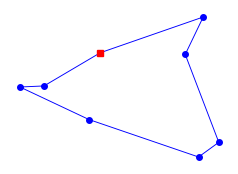

In [7]:
plot_tour(exhaustive_tsp(random_cities(8)))

The plot helps convince me that this is indeed the shortest tour.

# Convenience function: `run`

I will define `run` to run a TSP algorithm on a set of cities, plot the resulting tour, and print the tour length and run time.

In [8]:
def run(tsp: callable, cities: Cities):
    """Run a TSP algorithm on a set of cities and plot/print results."""
    t0   = time.perf_counter()
    tour = tsp(cities)
    t1   = time.perf_counter()
    L    = tour_length(tour)
    print(f"length {round(L):,d} tour of {len(cities)} cities in {t1 - t0:.3f} secs")
    plot_tour(tour)

Here is `run` in action:

length 23,470 tour of 8 cities in 0.086 secs


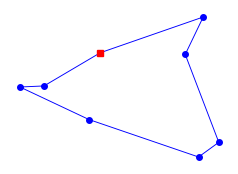

In [9]:
run(exhaustive_tsp, random_cities(8))

# Speedup for  `possible_tours`

The number of possible tours of *n* cities is the number of permutations, which is *n*! (the factorial of *n*), and thus there are  6 tours of 3 cities:

In [10]:
tuple(possible_tours({1, 2, 3}))

((1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1))

But a tour is a loop, so `(1, 2, 3)`, `(2, 3, 1)`, and `(3, 1, 2)` are three ways of describing exactly the same loop. I can redefine `possible_tours` to only include one representation of each loop by arbitrarily saying that a tour must start with the first city in the set of cities.  

In [11]:
def possible_tours(cities) -> List[Tour]:
    "Return a list of non-redundant tours (permutations of cities with first city first)."
    start, *others = cities
    return [[start, *perm] for perm in itertools.permutations(others)]

We can verify that for 3 cities there are now only 2 tours, not 6:

In [12]:
possible_tours({1, 2, 3})

[[1, 2, 3], [1, 3, 2]]

We can see that `exhaustive_tsp` can now do 9 cities in roughly the time it took to do 8 before:

length 22,412 tour of 9 cities in 0.151 secs


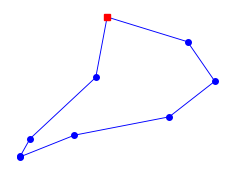

In [13]:
run(exhaustive_tsp, random_cities(9))

We can keep going to 10 cities, which takes about a second:

length 23,013 tour of 10 cities in 0.870 secs


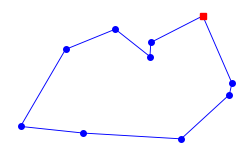

In [14]:
run(exhaustive_tsp, random_cities(10))

# General Strategies for Algorithm Design

It takes Exhaustive Search a second or so to solve a 10-city problem, so 12 cities would take about 2 minutes (11×12 times longer), and 15 cities would take days. 
There must be a better way ... 

To get inspired, here are some general  strategies for algorithm design: 

* **Brute Force Strategy**: The strategy used for `exhaustive_tsp`; as [Ken Thompson](https://en.wikipedia.org/wiki/Ken_Thompson) [says](https://www.brainyquote.com/quotes/ken_thompson_185574?src=t_brute_force), "*when in doubt, use brute force*."
* **Approximation Strategy**: If it is too hard to find an exact, optimal solution, consider an approximate, slightly suboptimal solution.
* **Greeedy Strategy**: To complete a multiple step problem, first do the step that appears to be best in the short run. Repeat. 
* **Improvement Strategy**: Use an existing algorithm to create a solution, then have another algorithm improve the solution.
* **Divide and Conquer Strategy**: Split the problem in half, solve each half, and combine the two partial solutions.
* **Ensemble Strategy**: Apply a set of algorithms to the problem, and pick the best solution. 
* **Stand on the Shoulders of Giants Strategy**: Find out what other people have done, and copy them.

Let's apply these strategies to develop some TSP algorithms.


#  Nearest Neighbor Algorithm: `nearest_tsp`

Here's a second TSP algorithm:

- **Nearest Neighbor TSP Algorithm:** *Create a partial tour that initially is just the start city. At each step extend the partial tour to the nearest unvisited neighbor of the last city in the partial tour, until there are no unvisited cities remaining.*

This is both an **approximation strategy** and a **greedy strategy**. It is an approximation, because it won't necessarily find the optimal tour. It is greedy because at each step it makes the choice that looks best in the short run (the nearest neighbor), even if that is not the best in the long run.



In [15]:
def nearest_tsp(cities, start=None) -> Tour:
    """Create a partial tour that initially is just the start city. 
    At each step extend the partial tour to the nearest unvisited neighbor 
    of the last city in the partial tour, while there are unvisited cities remaining."""
    start = start or first(cities)
    tour = [start]
    unvisited = set(cities) - {start}
    def extend_to(C): tour.append(C); unvisited.remove(C)
    while unvisited:
        extend_to(nearest_neighbor(tour[-1], unvisited))
    return tour

def first(collection): 
    """The first element of a collection."""
    return next(iter(collection))

def nearest_neighbor(A: City, cities) -> City:
    """Find the city C in cities that is nearest to city A."""
    return min(cities, key=lambda C: distance(C, A))

The exhaustive search considers all tours, so the run time for *n* cities is proportional to *n*! and [we say](https://en.wikipedia.org/wiki/Big_O_notation) it is *O*(*n*!). The nearest neighbor algorithm builds *n* links in the tour and at each step considers up to *n* possibilities, so we say it is *O*(*n*<sup>2</sup>). That means it runs a lot faster! While `exhaustive_tsp` could only do 10 cities in a second, `nearest_tsp` can do thousands. Here it is with 3,000 cities:

length 410,442 tour of 3000 cities in 0.682 secs


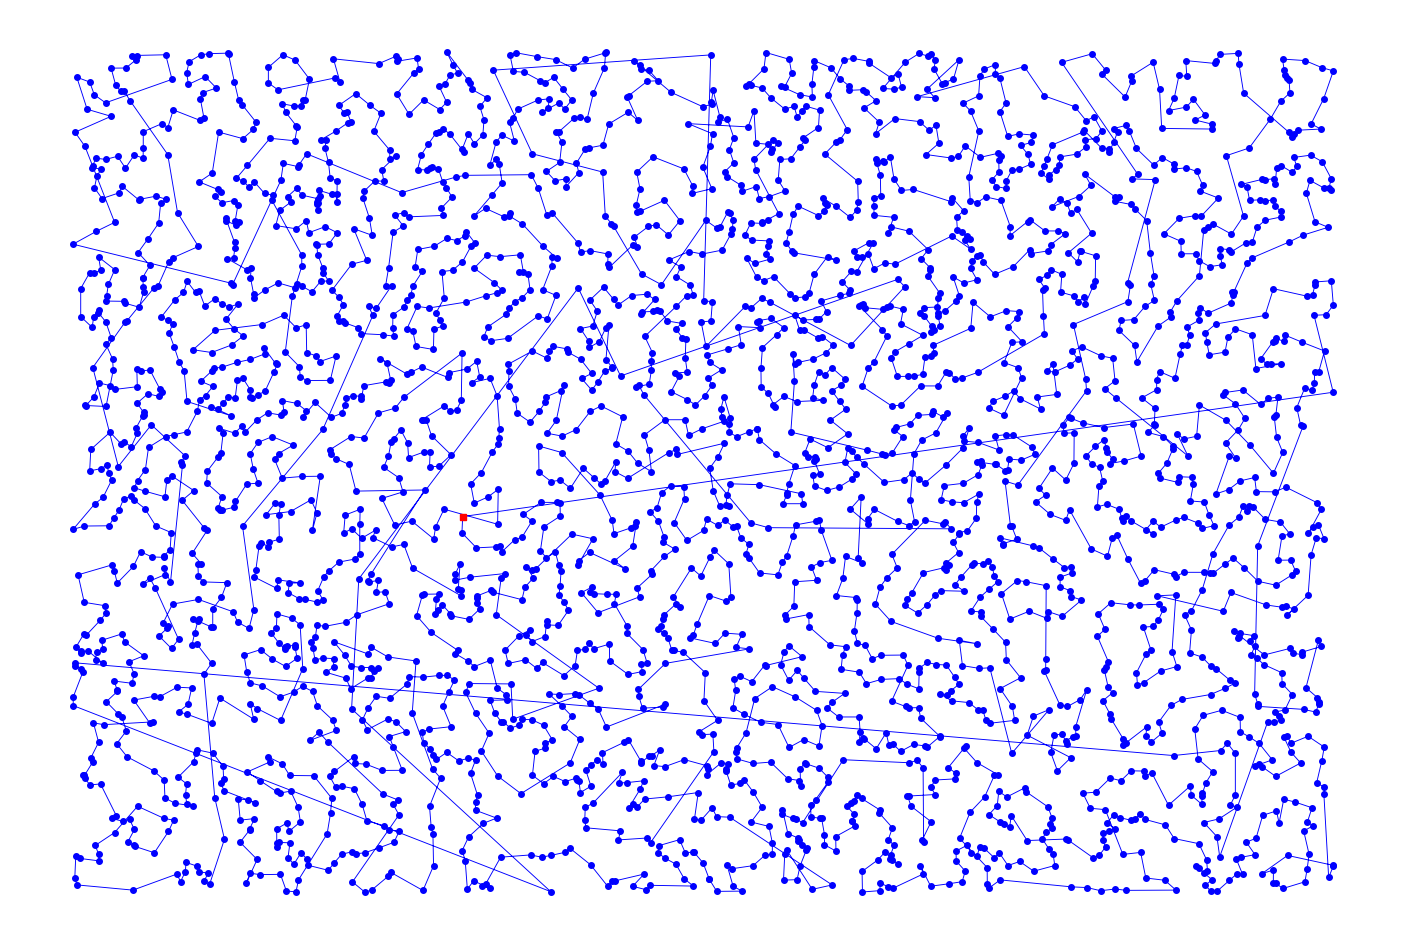

In [16]:
run(nearest_tsp, random_cities(3000))

# Real Cities

A tour of 3,000 random cities may look like a [Jackson Pollack](https://www.moma.org/artists/4675) painting, but I thought it would be fun to work on some *real* cities. I found a web page (now 404, but a copy is [here](https://raw.githubusercontent.com/norvig/pytudes/master/data/latlong.htm)) that lists coordinates of over 1000 cities in the USA (actually, the locations of airports in these cities), in this format:

     [TCL]  33.23   87.62  Tuscaloosa,AL
     [FLG]  35.13  111.67  Flagstaff,AZ
     [ANC]  61.17  150.02  Anchorage,AK

We can fetch the file if a local copy is not already in the current directory:

In [17]:
! [ -e latlong.htm ] || curl -O https://raw.githubusercontent.com/norvig/pytudes/master/data/latlong.htm

I define the function `parse_cities` to extract cities from a file in this format (skipping Alaska and Hawaii):

In [18]:
def parse_cities(text, skip=('AK', 'HI'), long_scale=-48, lat_scale=69) -> Cities:
    """Make a set of Cities from lines of text, skipping the specified states."""
    return Cities(City(int(long_scale * float(long)), int(lat_scale  * float(lat)))
                  for (lat, long, state) in re.findall(r'([\d.]+)\s+([\d.]+).+([A-Z][A-Z])', text)
                  if state not in skip)

USA = parse_cities(pathlib.Path('latlong.htm').read_text())

(You might be wondering about the `long_scale=-48, lat_scale=69` part. The issue is that computing distance from latitude and longitude requires [complicated trigonometry](http://en.wikipedia.org/wiki/Haversine_formula).  But we can get an approximation by assuming that latitude and longitude are on a flat rectangular grid. (This is a bad approximation if you're talking about links of 1,000 miles, but close enough for shorter links, as long as you're not too near the poles.)  I took the latitude of the center of the USA (Wichita, KS: latitude 37.65) and plugged it into a [Length Of A Degree Of Latitude
And Longitude Calculator](http://www.csgnetwork.com/degreelenllavcalc.html) to find that, in Wichita, one degree of latitude is 69 miles, and one degree of longitude is 48 miles.  I use -48 rather than +48 because the USA is west of the prime meridian.) 

I also found a [blog post](http://www.randalolson.com/2015/03/08/computing-the-optimal-road-trip-across-the-u-s/) by Randal S. Olson, who chose 50 landmarks across the USA and found a tour based on actual road-travel distances, not straight-line distance; I would need a new `distance` function to handle that. William Cook provides an
analysis, and a [tour that is shorter](http://www.math.uwaterloo.ca/tsp/usa50/index.html) than Randal's.

Now let's find a baseline nearest neighbor tour on the USA map:

length 53,364 tour of 1088 cities in 0.082 secs


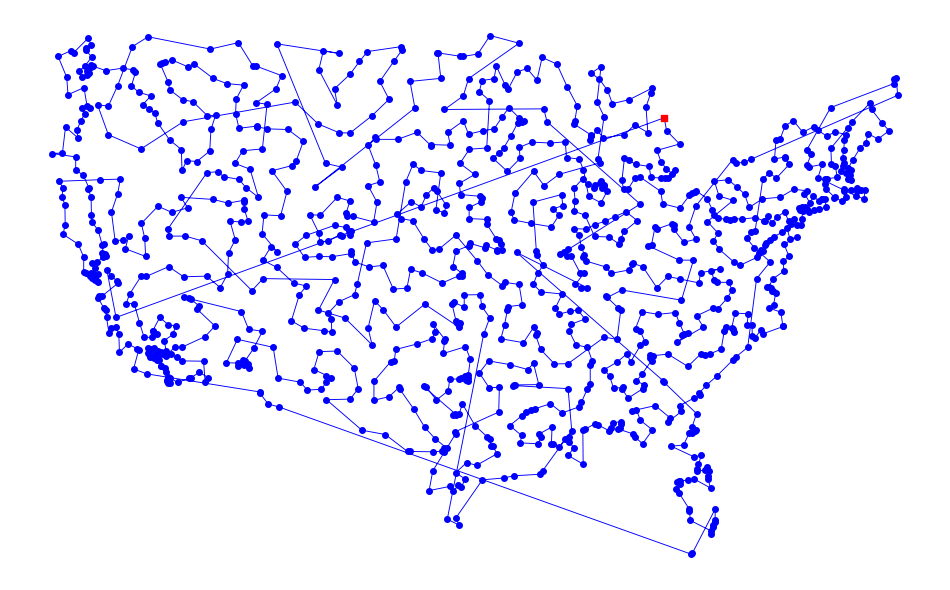

In [19]:
run(nearest_tsp, USA)



# Repeated Nearest Neighbor Algorithm: `rep_nearest_tsp`

The nearest neighbor algorithm is fast, whether it be on `random_cities(3000)` or `USA` or any other map. However, the resulting tour is not guaranteed to be optimal. For example:

length 25,408 tour of 10 cities in 0.000 secs


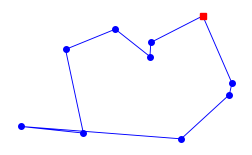

In [20]:
run(nearest_tsp, random_cities(10))

The `nearest_tsp` tour is about 10% longer than the optimal tour found by `exhaustive_tsp`,
but that will vary, depending on the set of cities, and also depending on the starting city that `nearest_tsp` chooses. 

That gives me an idea: Just as with buying lottery tickets, we can improve our chance of winning (at a cost) by trying more often.

- **Repetitive Nearest Neighbor Algorithm:** *Run the nearest neighbor algorithm repeatedly, each time with a different start city, and pick the resulting tour with the shortest total distance.*

This is an instance of the **ensemble strategy**, because providing a differentstart city to the function each time is like using a different algorithm each time. Which starting cities should we pick? I'll define a function to randomly `sample` the cities. (For reproducibility I'll give it a `seed` argument, as I did with `random_cities`). The parameter *k* says how many cities to sample.

In [21]:
def rep_nearest_tsp(cities, k=10):
    "Repeat nearest_tsp starting from k different cities; pick the shortest tour."
    return shortest(nearest_tsp(cities, start) for start in sample(cities, k))

def sample(population, n, seed=42) -> Iterable:
    "Return a list of n elements sampled from population. Set random.seed."
    random.seed((n, seed))
    return random.sample(population, min(n, len(population)))

Let's try it:

length 23,093 tour of 10 cities in 0.000 secs


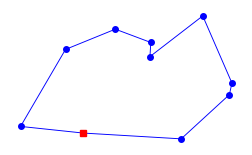

In [22]:
run(rep_nearest_tsp, random_cities(10))

So close! This tour is 0.3% longer than the optimal tour, but `rep_nearest_tsp` is a lot faster than `exhaustive_tsp`!

Let's compare on the USA map:

length 50,915 tour of 1088 cities in 0.885 secs


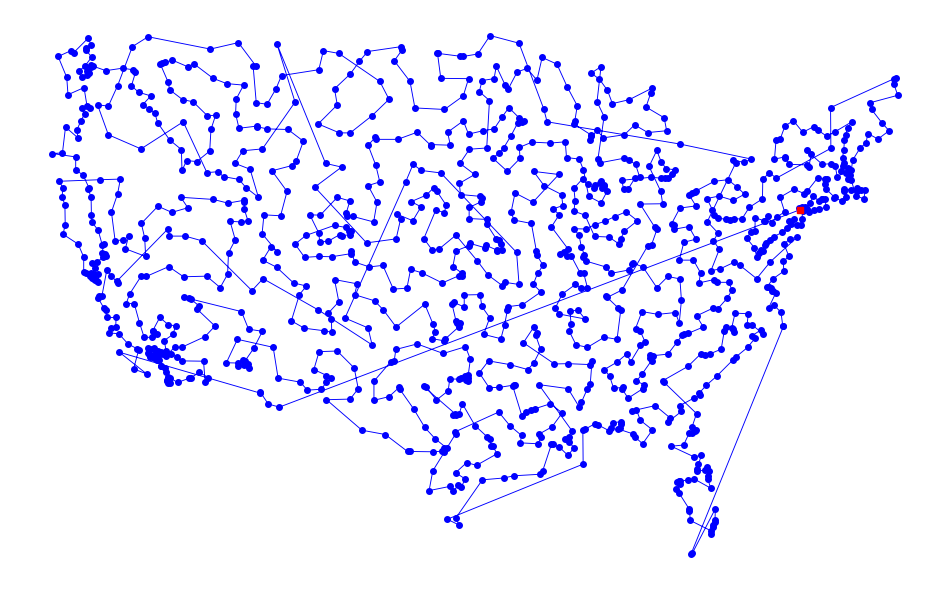

In [23]:
run(rep_nearest_tsp, USA)

That's 5% shorter than the `nearest_tsp` tour length, at the cost of a roughly 10-fold increase in run time.

# Improvement Strategy: Optimizing Links

Consider this tour of 10 non-random cities:

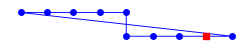

In [24]:
x10 = Tour(City(x, 0.9) for x in range(0, 5)) + Tour(City(x, 0) for x in range(4, 9))

plot_tour(rep_nearest_tsp(Cities(x10)))

No matter where `rep_nearest_tsp` starts, it ends up greeedily going to nearest neighbors and being stuck with a long diagonal link to get back to the other end; that long link is a mistake.

Could we modify nearest neighbors search to avoid making mistakes like this? That would be hard. Everything appears to be going well until we are forced to take the long diagonal link; we can't easily say which links before that are mistakes to avoid.  So, rather than tackling the difficult task of **avoiding** mistakes, the **improvement strategy** says to go ahead and make mistakes in creating the initial version of a tour, and then do the easier task of **fixing** the mistakes. Why is it easier to fix the mistakes? Because we can propose an alteration and get a definitive answer: either the change makes the whole tour shorter or it doesn't. 

In the diagram below, we propose altering the tour above by replacing the two red links with new green links.  If the total distance of the two green links is less than the total distance of the two red links, then we should make the alteration. 

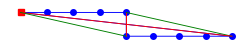

In [25]:
A, _, _, _, E, F, _, _, _, J = x10
plot_tour(x10, 'bo-')
plot_segment([E, F], 'r-');  plot_segment([E, J], 'g-')
plot_segment([A, J], 'r-');  plot_segment([A, F], 'g-')

When we are dealing with **Euclidean distance** (or any **[metric space](https://en.wikipedia.org/wiki/Metric_space)** for that matter), then by the [triangle inequality](https://en.wikipedia.org/wiki/Triangle_inequality) we can see that each green line is shorter than the sum of the two parts of the red lines that make up the rest of the triangle; thus we should make the alteration, and in general, anytime there are two links that **cross** in an **X** pattern, we should uncross the **X**. (With a non-Euclidean distance measure, the 2-opt optimizations still work, but the **crossed X** analogy does not apply.)

You can think of the alteration as deleting the two red links and adding the two green ones. Or you can think of it as **reversing a segment** of the tour: the crossed-links tour visits the top 5 cities in left-to-right order, then jags down to the bottom 5 cities, visiting them in left-to-right order. A better tour would visit the bottom five in right-to-left order. (Note that the total distance for a reversed segment is the same as the unreversed segment, because our `distance` is **symmetric**. If we were dealing with a non-symmetric `distance` function, we would have to keep track, for each segment, of the difference between traversing it one direction or the other, and incorporate that into the decision of whether reversing is an improvement.)

In the literature of TSP, this kind of improvement is called [**2-opt**](https://en.wikipedia.org/wiki/2-opt), because it involves deleting two links and replacing them with **two optimized** links. There is also a [**3-opt**](https://en.wikipedia.org/wiki/3-opt), which we won't cover, but you are welcome to look into it.

I'll define `opt2(tour)` to consider various segments, and reverse the ones that improve the tour. What segments should we consider? I don't know how to be clever about that, but I do know how to use **brute force**: try every subsegment. (I have an intuition (from experience with [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing)) that trying longer subsegments first would be better, so I'll write `subsegments` that way.) After I've tried all segments, if one of them did improve the tour I'll repeat the process until there are no improvements, then return the improved tour:

In [26]:
def opt2(tour) -> Tour:
    "Perform 2-opt segment reversals to optimize tour."
    changed = False
    old_tour = list(tour) # make a copy
    for (i, j) in subsegments(len(tour)):
        if reversal_is_improvement(tour, i, j):
            tour[i:j] = reversed(tour[i:j])
            changed = True
    return (tour if not changed else opt2(tour))
        
def reversal_is_improvement(tour, i, j) -> bool:
    "Would reversing the segment `tour[i:j]` make the tour shorter?" 
    # Given tour [...A,B--C,D...], would reversing B--C make the tour shorter?
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    return distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D)

cache = functools.lru_cache(None) # Or just `functools.cache` in Python 3.9+
        
@cache # All tours of length N have the same subsegments, so cache them.
def subsegments(N) -> Tuple[Tuple[int, int]]:
    "Return (i, j) index pairs denoting tour[i:j] subsegments of a tour of length N."
    return tuple((i, i + length)
                 for length in reversed(range(2, N - 1))
                 for i in range(N - length))

We can see that `opt2` does the trick on the 10 cities:

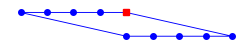

In [27]:
plot_tour(opt2(x10))

# Tools for Comparing Results

We're about to get into comparing different algorithms, with and without `opt2`. 

I will rewrite `run` to perform a longer list of duties:

- As before, `run` will **run** a TSP algorithm on a set of cities, **timing** how long it takes.
- I will make `Tour` be a class, that inherits from `list`, but can be annotated with 
- Each `run` will **annotate** the save and return a **`Result`** object describing the run, the resulting tour, and the run time.
- If an **optimization function** is specified with the `opt` parameter, first run the unoptimized version, save the result for it, then run the optimizer and save that result, with the added run time.
- A **`@cache`** of results means a previously-run result can just be fetched, saving run time.
- I'll add an **`assert`** statement to verify the tour is valid.
- Plotting results will no longer be the responsibility of `run`; instead call `plot_result(result)`.
- The function `runs` does a run for each of several TSP algorithms, then calls `plot` for the last one, and returns a list of all the results on the input cities.

In [28]:
class Result(namedtuple('_', 'tsp, opt, tour, cities, secs')):
    """A `Result` records the results of a `run` on a TSP."""
    def __repr__(self): 
        best = min([length(r) for r in all_results[self.cities]], default=length(self))
        return (f"{name(self.tsp, self.opt):>25}: length {round(length(self)):,d} tour "
                f"({length(self)/best:5.1%}) in {self.secs:6.3f} secs")   

all_results = defaultdict(list) # {cities: [tour, ...]}

def name(tsp, opt=None) -> str: return tsp.__name__ + (('+' + opt.__name__) if opt else '')
    
def length(result: Result) -> float: return tour_length(result.tour)

@cache
def run(tsp: TSP, cities: Cities, opt=None) -> Result:
    """Run a TSP algorithm on a set of cities and return results."""
    if opt: # recursively run unoptimized version; add .secs for that to opt(tour)
        res0  = run(tsp, cities, None)
        t0    = time.perf_counter()
        tour  = opt(Tour(res0.tour))
        t1    = time.perf_counter()
        secs  = res0.secs + t1 - t0
    else: # run the tsp
        t0    = time.perf_counter()
        tour  = tsp(cities)
        t1    = time.perf_counter()
        secs  = t1 - t0
    result = Result(tsp, opt, tour, cities, secs)
    all_results[cities].append(result)
    assert valid_tour(tour, cities)
    return result

def runs(tsps, cities, opts=(None, opt2)) -> List[Result]:
    """Run each of the tsps on the cities, and return a list of all results on `cities`."""
    for tsp, opt in itertools.product(tsps, opts):
        run(tsp, cities, opt)
    all_results[cities].sort(key=length)
    best = all_results[cities][0]
    plot_tour(best.tour, title=repr(best))
    return all_results[cities]

# Comparing 2-opt Optimizations

Now that we have the 2-opt optimization function, let's run it on four variations of the nearest neighbor algorithm:
1. `Tour` (run nearest neighbor zero times (just take the cities in given order), then 2-opt)
2. `nearest_tsp` (run nearest neighbor once, then 2-opt)
3. `rep_nearest` (run nearest neighbor k=10 times, then 2-opt)
4. `rep_opt2_nearest_tsp` (run nearest neighbor followed by 2-opt, k=10 times)

Let's see:

[     rep_opt2_nearest_tsp: length 44,317 tour (100.0%) in 16.662 secs,
 rep_opt2_nearest_tsp+opt2: length 44,317 tour (100.0%) in 16.995 secs,
      rep_nearest_tsp+opt2: length 44,473 tour (100.4%) in  2.137 secs,
          nearest_tsp+opt2: length 45,105 tour (101.8%) in  1.768 secs,
                 list+opt2: length 46,460 tour (104.8%) in  2.929 secs,
           rep_nearest_tsp: length 50,915 tour (114.9%) in  0.798 secs,
               nearest_tsp: length 53,364 tour (120.4%) in  0.080 secs,
                      list: length 1,122,001 tour (2531.8%) in  0.000 secs]

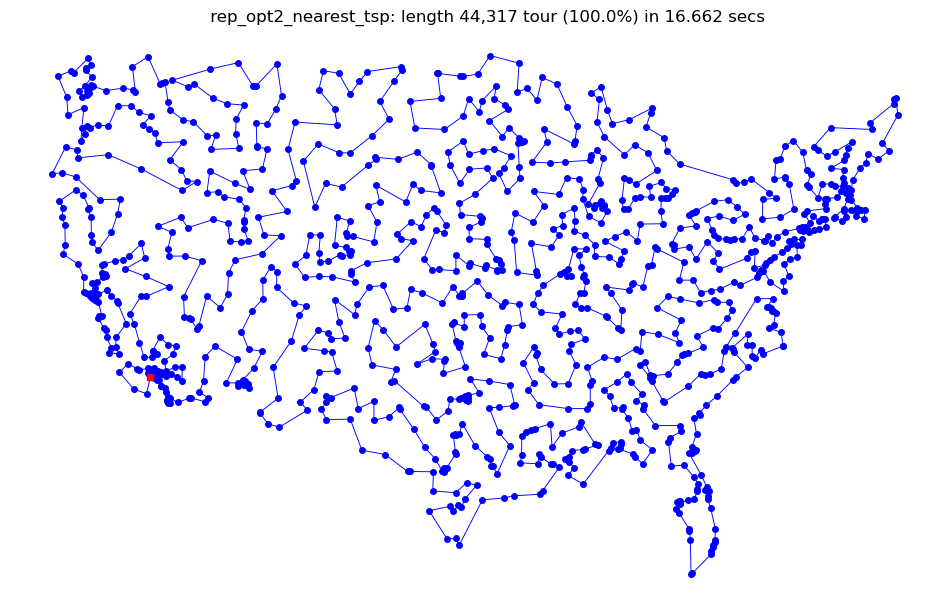

In [29]:
def rep_opt2_nearest_tsp(cities, k=10) -> Tour: 
    """Apply 2-opt to *each* of the repeated nearest neighbors tours."""
    return shortest(opt2(nearest_tsp(cities, start)) for start in sample(cities, k))

runs([Tour, nearest_tsp, rep_nearest_tsp, rep_opt2_nearest_tsp], USA) 

I notice that:
- `opt2` makes a **big** difference; all the optimized results are better than all the unoptimized ones.
- The best result is the one that calls `opt2` the most: `rep_opt2_nearest_tsp` does 10 nearest neighbor trials and calls `opt2` on each one.
- An `opt2` application on 1088 cities takes about a couple of seconds; a `nearest_tsp` application only about 0.1 seconds.
- We should be happy to have saved 9,000 miles of travel (between the worst and best results) in 20 seconds of computing time; that's 1.6 million miles per hour!

# Greedy TSP Algorithm: `greedy_tsp`

Let's return to the **greedy strategy**. The Nearest Neighbor Algorithm followed the greedy strategy in always choosing the neighbor that is nearest to the previous city in the tour. Another way to be greedy is to at each step incorporate the shortest possible link, **anywhere** in the map, not just from the previous city in the partial tour. It works like this: 

> **Greedy Algorithm:** *Maintain a set of **segments**; intially each city defines its own 1-city segment. Find the shortest possible link that connects two endpoints of two different segments, and join those segments with that link. Repeat until we form a single segment that tours all the cities.*

On each step of the algorithm, we want to *"find the shortest possible link that connects two endpoints."* That seems like an expensive operation to do on each step. So we will add some data structures  to speed up the computation:  

1. Pre-compute a list of links, sorted by shortest link first. A link is a pair of cities: `(A, B)`.
2. Maintain a dict that maps **endpoints** to **segments**, e.g. `{A: [A, B, C], C: [A, B, C], D: [D]}` means that `A` and `C` are the endpoints of segment `[A, B, C]` and `D` is the only endpoint of a 1-city segment. 
3. Go through the links in shortest-distance-first order. Given the dict listed above, suppose the next shortest link is:
    - `(B, D)`: We can't use it, because `B` is in the middle of a segment; it is already attached to `A` and `C`, and by definition, those are shorter links. 
    - `(A, C)`: We can't use it; that would make `[A, B, C]` into a closed loop. 
    - `(C, D)`: We will use it: join the two segments together, giving the updated endpoints dict: `{A: [A, B, C, D], D: [A, B, C, D]}`.
4. Stop when the newly created segment contains all the cities.

Here is the code:


In [30]:
def greedy_tsp(cities):
    """Go through links, shortest first. If a link can join segments, do it."""
    endpoints = {C: [C] for C in cities} # A dict of {endpoint: segment}
    links = itertools.combinations(cities, 2)
    for (A, B) in shortest_links_first(cities):
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            joined_segment = join_segments(endpoints, A, B)
            if len(joined_segment) == len(cities):
                return joined_segment
            
def shortest_links_first(cities) -> List[Link]:
    "Return all links between cities, sorted shortest first."
    return sorted(itertools.combinations(cities, 2), key=lambda link: distance(*link))
            
# TODO: join_segments

**Note:** The `endpoints` dict serves two purposes. First, the keys of the dict are cities that are endpoints of some segment, making it possible to ask "`A in endpoints`" to see if city `A` is an endpoint. Second, the value of `endpoints[A]` is the segment that `A` is an endpoint of, making it possible to ask "`endpoints[A] != endpoints[B]`" to make sure that the two cities are endpoints of different segments, not of the same segment (we don't want to join a segment to itself and form a loop).

For the `join_segments` function, I first make sure that `A` is the last element of one segment and `B` is the first element of the other, by reversing segments if necessary.  Then I add the B segment on to the end of the A segment. Finally, I update the `endpoints` dict by deleting `A` and `B` and then adding the two endpoints of the new segment: 

In [31]:
def join_segments(endpoints, A, B):
    "Join segments [...,A] + [B,...] into one segment. Maintain `endpoints`."
    Aseg, Bseg = endpoints[A], endpoints[B]
    if Aseg[-1] is not A: Aseg.reverse()
    if Bseg[0]  is not B: Bseg.reverse()
    Aseg += Bseg
    del endpoints[A], endpoints[B] 
    endpoints[Aseg[0]] = endpoints[Aseg[-1]] = Aseg
    return Aseg

Let's try out the `greedy_tsp` algorithm, with and without 2-opt, on the USA map:

[     rep_opt2_nearest_tsp: length 44,317 tour (100.0%) in 16.662 secs,
 rep_opt2_nearest_tsp+opt2: length 44,317 tour (100.0%) in 16.995 secs,
           greedy_tsp+opt2: length 44,417 tour (100.2%) in  2.162 secs,
      rep_nearest_tsp+opt2: length 44,473 tour (100.4%) in  2.137 secs,
          nearest_tsp+opt2: length 45,105 tour (101.8%) in  1.768 secs,
                 list+opt2: length 46,460 tour (104.8%) in  2.929 secs,
           rep_nearest_tsp: length 50,915 tour (114.9%) in  0.798 secs,
                greedy_tsp: length 51,129 tour (115.4%) in  0.407 secs,
               nearest_tsp: length 53,364 tour (120.4%) in  0.080 secs,
                      list: length 1,122,001 tour (2531.8%) in  0.000 secs]

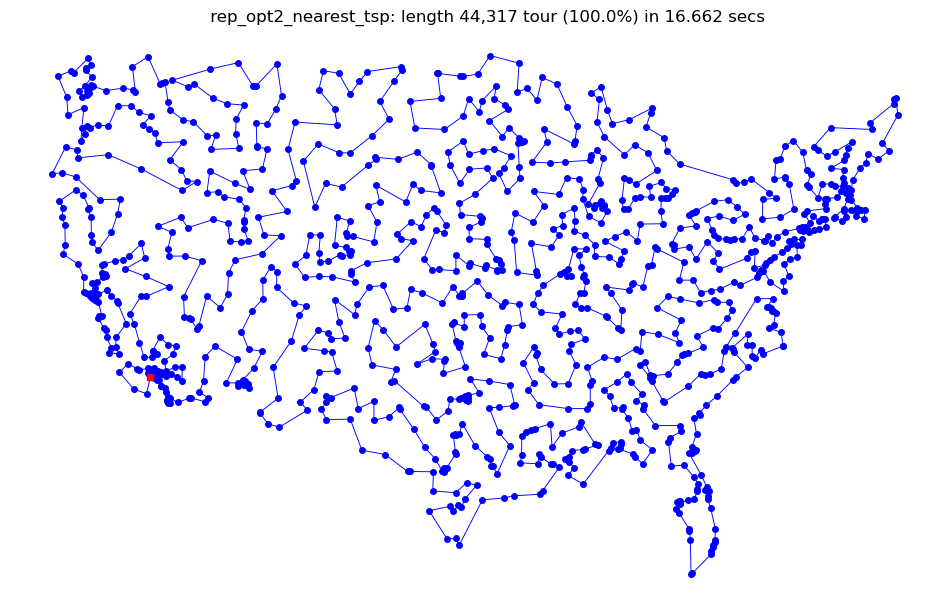

In [32]:
runs([greedy_tsp], USA)

This time I notice that:
- Without 2-opt, the greedy algorithm performs poorly, but better than nearest neighbors.
- With 2-opt, the greedy algorithm is comparable (in run time and tour length) to the 10-repetition nearest neighbors algorithm.
- To really decide which algorithm is better, we'll need more than just one problem. Latter we will **benchmark** algorithms on multiple problems.

What about a repetitive greedy algorithm?  That might be a good idea, but there is no obvious way to do it, because the greedy algorithm as it stands doesn't have a parameter that can be varied on each repeated run.

## Visualizing the Greedy Algorithm

I would like to visualize the process of joining segments.  Although I dislike copy-and-paste (because it violates the [*Don't Repeat Yourself*](http://en.wikipedia.org/wiki/Don%27t_repeat_yourself) principle), I'll  make a new version of `greedy_tsp` called `greedy_tsp_generator` that yields the `endpoints` dict on every iteration. Then I'll define `plot_greedy_tsp` to plot progressive versions of the map when the number of segments hits certain milestones.

In [33]:
def greedy_tsp_generator(cities) -> Iterable[Dict[City, Segment]]:
    """Go through links, shortest first. If a link can join segments, do it.
    Yield the dict of {endpoint: segment} on each iteration."""
    endpoints = {C: [C] for C in cities} # A dict of {endpoint: segment}
    links = itertools.combinations(cities, 2)
    for (A, B) in sorted(links, key=lambda link: distance(*link)):
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            joined_segment = join_segments(endpoints, A, B)
            yield endpoints
            if len(joined_segment) == len(cities):
                return

def plot_greedy_tsp(cities, plot_sizes=(1000, 500, 250, 125, 60, 30, 15, 10, 5, 2, 1)):
    """Plot segments during the process of `greedy_tsp`, at specified plot_sizes."""
    for endpoints in greedy_tsp_generator(cities):
        segments = set(map(tuple, endpoints.values()))
        if len(segments) in plot_sizes:
            for s in segments:
                plot_segment(s, style='o-')
            plt.title(f'{len(segments)} segments:')
            plt.show()

The full USA map would be too busy to see what's going on, so I'll sample about 1/3 of the cities:

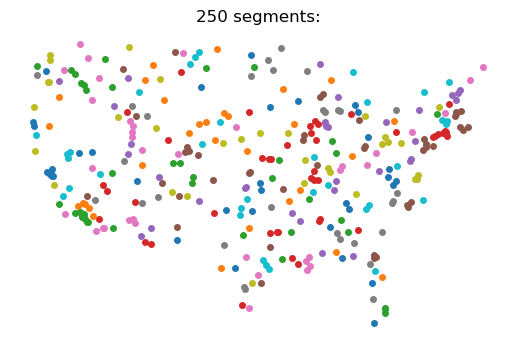

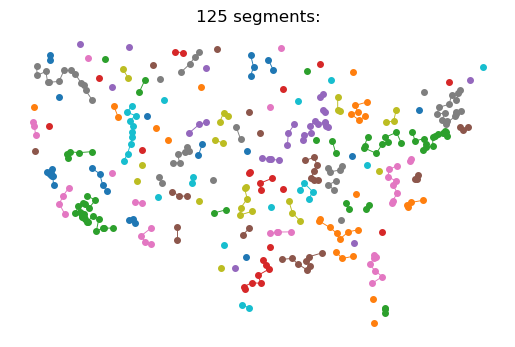

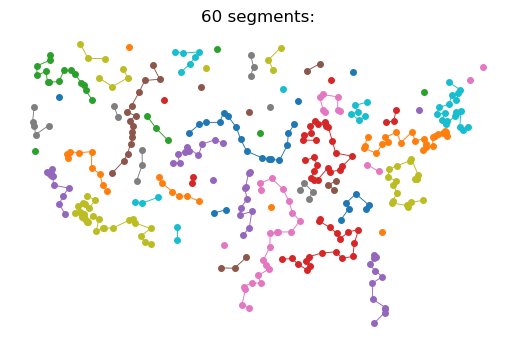

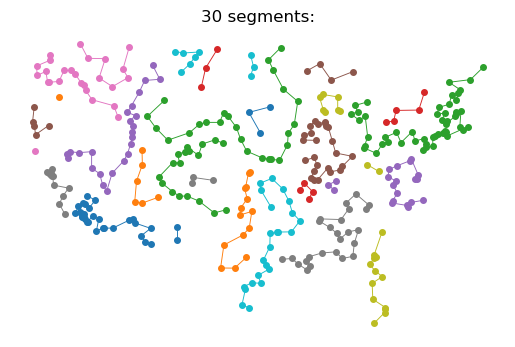

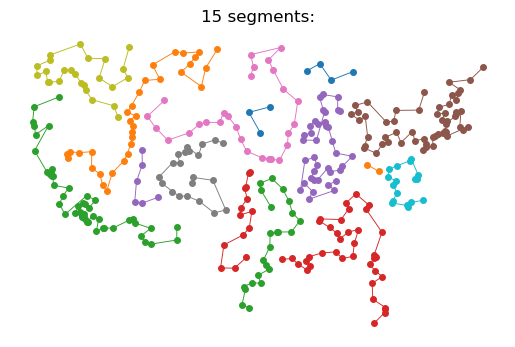

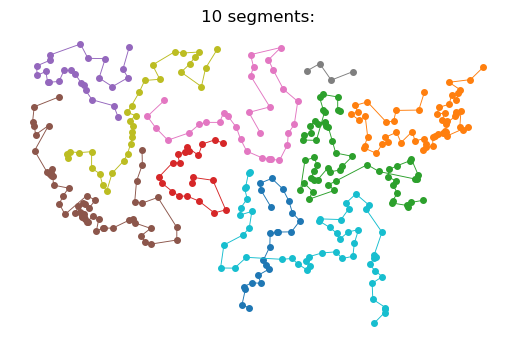

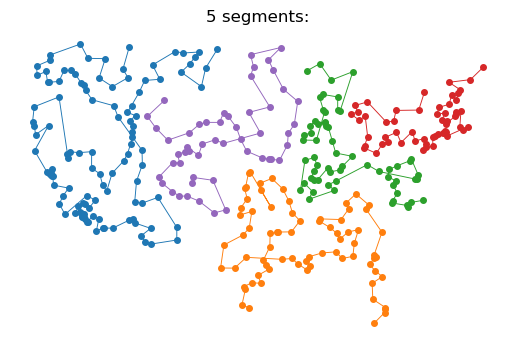

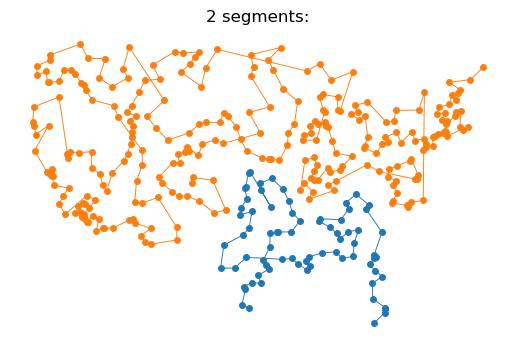

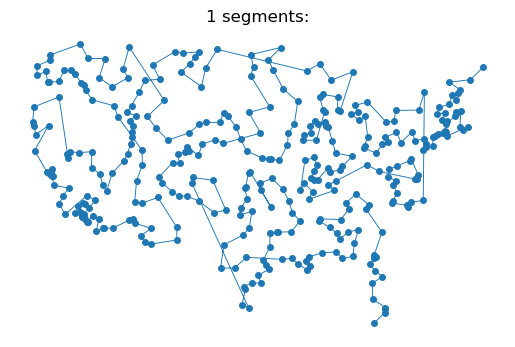

In [34]:
USA360 = Cities(sample(USA, 360))

plot_greedy_tsp(USA360)

# Divide and Conquer: `divide_tsp`

The next general strategy to consider is **divide and conquer**.  Suppose we have an algorithm, like `exhaustive_tsp`, that is too slow to apply to a large set of cities. We could divide the problem into smaller pieces, and then combine those pieces:

1. Split the set of cities in half.
2. Find a tour for each half.
3. Join those two tours into one.

When the number of cities, *n*, is small, step 2 can be done directly by the exhaustive search algorithm.  But when *n* is large, step 2 is done with a recursive call, breaking each half into two smaller pieces. 


Here's an example with six cities. We split them into two halves of 3 cities each, for which we can easily create tours:

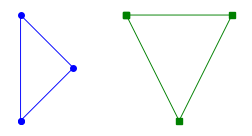

In [35]:
A, B, C, D, E, F = A2F = [City(*p) for p in ((0, 0), (1, 1), (0, 2), (2, 2), (3, 0), (4, 2))]

plt.figure(figsize=(3, 2))
plot_segment([A, B, C, A], 'bo-')
plot_segment([D, E, F, D], 'gs-')

Now to join the two halves together, the first thing I do is delete a link from each half. There are 3 &times; 3 ways to do that; here's one:

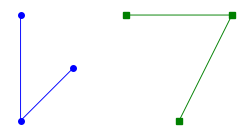

In [36]:
plt.figure(figsize=(3, 2))
plot_segment([C, A, B], 'bo-')
plot_segment([D, F, E], 'gs-')

Now connect the two halves back together. There are two ways to do that; this is the better way:

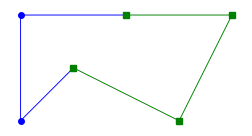

In [37]:
plt.figure(figsize=(3, 2))
plot_segment([D, C, A, B], 'bo-')
plot_segment([D, F, E, B], 'gs-')

Now we have a feel for what we have to do.  I'll name the divide and conquer algorithm `divide_tsp`.  If the size of the set of cities is less than *split*, then find the shortest tour using `exhaustive_tsp`. If there are *split* cities or more, then split the cities in half (with `split_cities`), find a tour for each half (using `divide_tsp` recursively), and join the two tours together (with `join_tours`): 

In [38]:
def divide_tsp(cities, split=7) -> Tour:
    """Find a tour by divide and conquer: if number of cities is `split` or more, then split
    the cities in half, solve each half recursively, then join those two tours together.
    Otherwise solve with `exhaustive_tsp`."""
    if len(cities) < split:
        return exhaustive_tsp(cities)
    else:
        half1, half2 = split_cities(cities)
        return join_tours(divide_tsp(half1, split), divide_tsp(half2, split))
    
# TODO: split_cities, join_tours

How do we split a set of cities?  In the non-Euclidean case, there would be no easy way to make a good split. But with each city having *x* and *y* coordinates, 
my approach is to imagine drawing an axis-aligned rectangle that is just big enough to contain all the cities. If the rectangle  is wider than it is tall, then order all the cities by *x* coordinate and split that ordered list in half.  If the rectangle is taller than it is wide, order and split the cities by *y* coordinate. 

In [39]:
def X_(city) -> int: "X coordinate"; return city.real
def Y_(city) -> int: "Y coordinate"; return city.imag

def split_cities(cities) -> Tuple[List[City], List[City]]:
    "Split cities vertically if map is wider; horizontally if map is taller."
    coord  = (X_ if (extent(Xs(cities)) > extent(Ys(cities))) else Y_)
    cities = sorted(cities, key=coord)
    middle = len(cities) // 2
    return cities[:middle], cities[middle:]

def extent(numbers) -> float: return max(numbers) - min(numbers)

Now for the tricky part: joining two tours together. First we consider all ways of deleting one link from each of the two tours.  If we delete a link from a tour we get a segment.  We are representing segments as lists of cities, the same surface representation as tours.  But there is a difference in their interpretation.  The tour `[C, A, B]` is a triangle of three links, but the segment `[C, A, B]` consists of only two links, from `C` to `A` and from `A` to `B`. The segments that result from deleting a link from the tour `[C, A, B]` are:

     [C, A, B],  [A, B, C],  [B, C, A]

You may recognize these as the *rotations* of the segment `[C, A, B]`. So any candidate combined tour consists of taking a rotation of the first tour, and appending to it a rotation of the second tour, with one caveat: when we go to append the two segments, there are two ways of doing it: either keep the second segment as is, or reverse the second segment.

In [40]:
def join_tours(tour1, tour2):
    "Consider all ways of joining the two tours together, and pick the shortest."
    segments1, segments2 = rotations(tour1), rotations(tour2)
    return shortest(s1 + s3
                    for s1 in segments1
                    for s2 in segments2
                    for s3 in (s2, s2[::-1]))

def rotations(sequence):
    "All possible rotations of a sequence."
    # A rotation is some suffix of the sequence followed by the rest of the sequence.
    return [sequence[i:] + sequence[:i] for i in range(len(sequence))]

Let's divide and conquer! First the 6 cities `A` to `F`:

[               divide_tsp: length 12 tour (100.0%) in  0.000 secs,
           divide_tsp+opt2: length 12 tour (100.0%) in  0.000 secs]

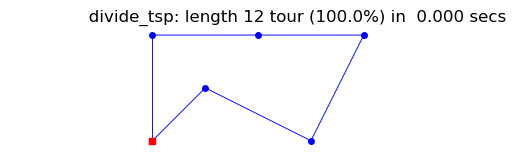

In [41]:
runs([divide_tsp], Cities(A2F))

Now the USA map. But the `divide_tsp` algorithm, as I have written it, is slow. So I'll use the smaller sample of cities from USA, and compare `divide_tsp` to `greedy_tsp`, with and without `opt2`:

[          greedy_tsp+opt2: length 26,089 tour (100.0%) in  0.176 secs,
           divide_tsp+opt2: length 27,108 tour (103.9%) in  4.848 secs,
                greedy_tsp: length 28,926 tour (110.9%) in  0.025 secs,
                divide_tsp: length 29,177 tour (111.8%) in  4.654 secs]

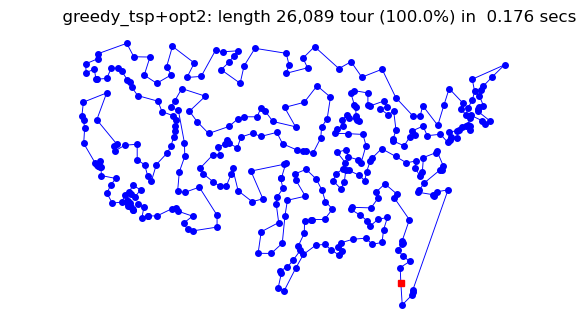

In [42]:
runs([divide_tsp, greedy_tsp], USA360)

The conclusion: `divide_tsp` does not perform as well as `greedy_tsp` on this example, and is much slower.

# Shoulders of Giants: Minimum Spanning Tree Algorithm


| ![Joseph Kruskal (Wikipedia)](http://people.inf.elte.hu/hytruongson/Kruskal/J.Kruskal.jpg) |
|----|
| [Joseph Kruskal (Wikipedia)](https://en.wikipedia.org/wiki/Joseph_Kruskal) |



I hope you now believe that you could have come up with some ideas for solving the TSP, using the set of **strategies**. But even if you can't come up with something all on your own, you can follow the **Stand on the Shoulders of Giants Strategy**, also known as the **[Just Google it Strategy](http://bit.ly/XNGt2y)**, in which case you'll no doubt find a giant of a mathematician, [Joseph Kruskal](http://en.wikipedia.org/wiki/Joseph_Kruskal), who, in 1956, published [a paper](http://www.cmat.edu.uy/~marclan/TAG/Sellanes/Kruskal.pdf) that led to an algorithm that
most people would not have thought of on their own (I know I wouldn't have):
> **Minimum Spanning Tree Traversal Algorithm:** *Construct a Minimum Spanning Tree, then do a pre-order traversal.  That will give you a tour that is guaranteed to be no more than twice as long as the minimal tour.* 

What does all this jargon mean? It is part of *[graph theory](https://en.wikipedia.org/wiki/Graph_theory)*, the study of vertexes and links.  Here is a glossary of terms:

* A **graph** is a collection of vertexes and links.
* A **vertex** is a point (such as a city).
* A **link** is an edge between two vertexes. Links have lengths.
* A **directed graph** is a graph where the links have a direction.  We say that the link goes from the **parent** vertex to the **child** vertex.
* A **tree** is a directed graph in which there is one distinguished vertex called the **root** that has no parent; every other vertex has exactly one parent. 
* A **spanning tree** (of a set of vertexes) is a tree that contains all the vertexes.    
* A **minimum spanning tree** is a spanning tree with the smallest  sum of link lengths.
* A **traversal** of a tree is a way of visiting all the vertexes in some order.
* A **pre-order traversal** means that you visit the root first, then do a pre-order traversal of each of the children.


We will implement a directed graph as a dict of `{parent: [child, ...]}`. Now our plan is:

1. Implement an algorithm to create a minimum spanning tree, `mst`.
2. Implement a tree traversal; that will give us our `mst_tsp` algorithm.
3. Understand the guarantee.

# Creating a Minimum Spanning Tree (`mst`)


Now let's see how to create a minimum spanning tree (or MST).  Kruskal has a very nice algorithm to find MSTs, but with what we have done so far, it will be a bit easier to implement [another Giant](https://en.wikipedia.org/wiki/Robert_C._Prim)'s algorithm:

> **[Prim's algorithm for creating a MST](http://en.wikipedia.org/wiki/Prim%27s_algorithm):** *List all the links and sort them, shortest first.  Initialize a tree to be a single root city (we'll arbitrarily choose the first city). Now repeat the following until the tree contains all the cities: find the shortest link that links a city (A) that is in the tree to a city (B) that is not yet in the tree, and add B to the list of A's children in the tree.*

Here's the code. One tricky bit: In the first line inside the `while` loop, we assign `(A, B)` to be a link in which exactly one of `A` or `B` is in the tree, using the exclusive-or operator, `^`.  Then in the next line, we make sure that `A` is the one that is in the tree and B is not, by swapping if necessary.

In [43]:
def mst(vertexes):
    """Given a set of vertexes, build a minimum spanning tree: a dict of the form 
    {parent: [child...]}, spanning all vertexes."""
    tree  = {first(vertexes): []} # the first city is the root of the tree.
    links = shortest_links_first(vertexes)
    while len(tree) < len(vertexes):
        (A, B) = first((A, B) for (A, B) in links if (A in tree) ^ (B in tree))
        if A not in tree: (A, B) = (B, A)
        tree[A].append(B)
        tree[B] = []
    return tree

Let's see what a minimum spanning tree looks like:

37860.30782270789

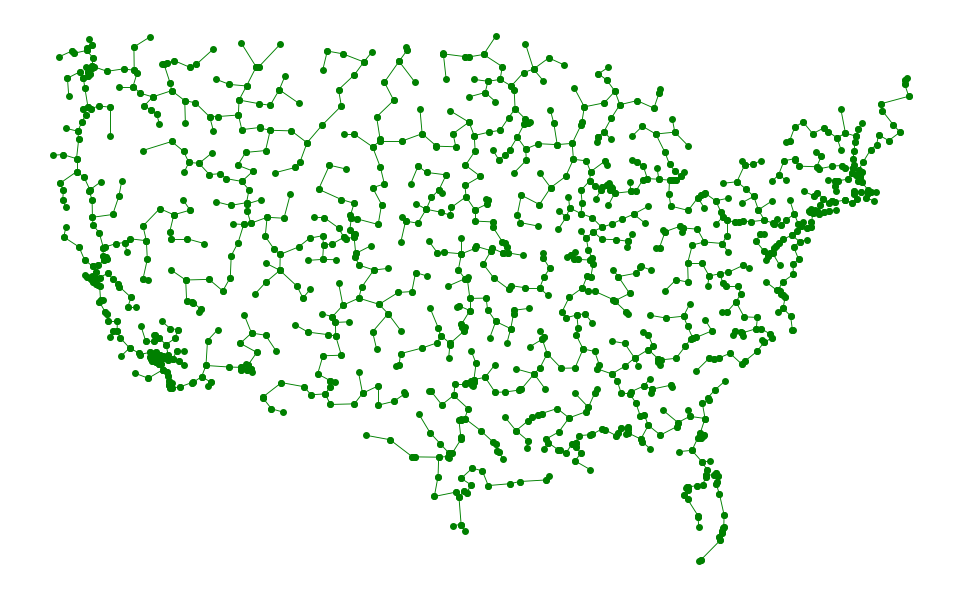

In [44]:
def plot_graph(graph) -> float:
    "Given a graph of the form {parent: [child...]}, plot vertexes and links."
    vertexes = {v for parent in graph for v in graph[parent]} | set(graph)
    links    = [(parent, child) for parent in graph for child in graph[parent]]
    if len(graph) > 1000: plt.figure(figsize=(15, 7.5))
    for link in links:
        plot_segment(link, 'go-')
    return sum(distance(p, c) for (p, c) in links)

plot_graph(mst(USA))

This certainly looks like a spanning tree.  But can we prove it is a **minimum** spanning tree?  

1. The output is a **tree** because:
    - Every city is connected by a path from the root.
    - Every city only gets one parent (we only add a B that is not in the tree), so there can be no loops. 
2. The output is a **spanning tree** because it contains all the cities.
3. The output is a **minimum spanning tree** because each city was added with the shortest possible link.  Suppose this algorithm produces the tree T. For another putative spanning tree to be shorter, it would have to contain at least one city B whose link from its parent was shorter than the link in T. But that is not possible, because the algorithm always chooses the shortest possible link from B's parent, A, to B.


# Turning a Minimum Spanning Tree into a Tour (`mst_tsp`)


Given a minimum spanning tree, we can generate a tour by doing a pre-order traversal, which means the tour starts at the root, then visits all the cities in the pre-order traversal of the first child of the root, followed by the pre-order traversals of any other children.

In [45]:
def mst_tsp(cities) -> Tour:
    "Create a minimum spanning tree and walk it in pre-order."
    return Tour(preorder_traversal(mst(cities), first(cities)))

def preorder_traversal(tree, root):
    "Traverse tree in pre-order, starting at root of tree."
    yield root
    for child in tree.get(root, ()):
        yield from preorder_traversal(tree, child)

You can think of this as starting at the root of the tree and going around the outside of the tree, as if you were walking with your hand always touching a link, but skipping cities you have already been to.

Let's see what `mst_tsp` can do on the USA map:

[     rep_opt2_nearest_tsp: length 44,317 tour (100.0%) in 16.662 secs,
 rep_opt2_nearest_tsp+opt2: length 44,317 tour (100.0%) in 16.995 secs,
           greedy_tsp+opt2: length 44,417 tour (100.2%) in  2.162 secs,
      rep_nearest_tsp+opt2: length 44,473 tour (100.4%) in  2.137 secs,
          nearest_tsp+opt2: length 45,105 tour (101.8%) in  1.768 secs,
              mst_tsp+opt2: length 45,250 tour (102.1%) in  2.878 secs,
                 list+opt2: length 46,460 tour (104.8%) in  2.929 secs,
           rep_nearest_tsp: length 50,915 tour (114.9%) in  0.798 secs,
                greedy_tsp: length 51,129 tour (115.4%) in  0.407 secs,
               nearest_tsp: length 53,364 tour (120.4%) in  0.080 secs,
                   mst_tsp: length 58,201 tour (131.3%) in  0.485 secs,
                      list: length 1,122,001 tour (2531.8%) in  0.000 secs]

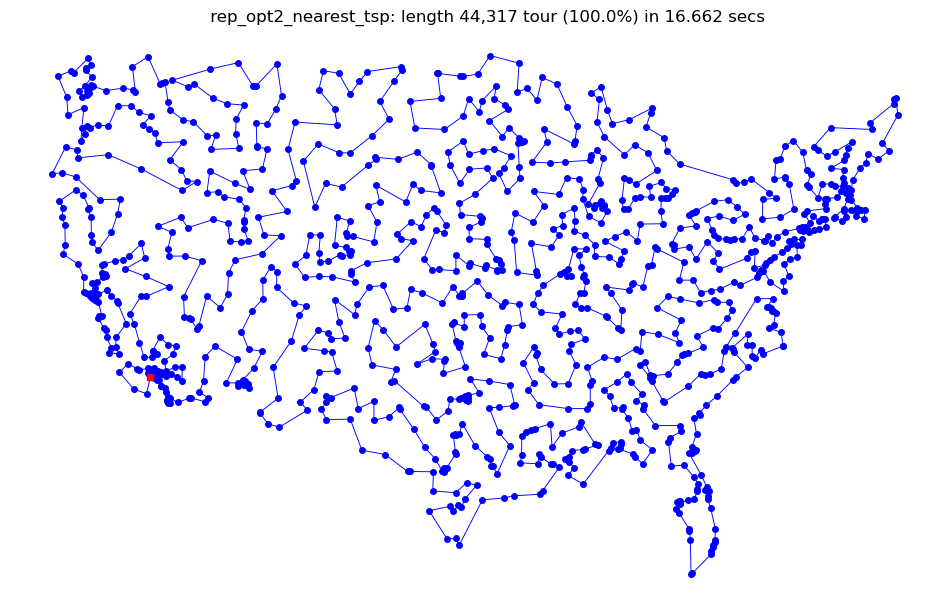

In [46]:
runs([mst_tsp], USA)

We see that `mst_tsp` performs poorly compared to the other algorithms. 

Why would anyone want to use the minimum spanning tree algorithm, when the nearest neighbor algorithm is simpler to describe, simpler to implement, runs faster, and produces shorter tours? 

# Guaranteed Tour Length

The "giant" thing about the minimum spanning tree algorithm is that it comes with a *guarantee*, which none of the other algorithms offer (except for `exhaustive_tsp`, which is guaranteed to find the optimal algorithm, if it has enough time to complete). The algorithm  guarantees that the tour length will be no worse than twice as long as the optimal tour.  (And, with a bit more [complication](https://en.wikipedia.org/wiki/Christofides_algorithm), you can modify it to give a guarantee of 1.5 times longer.)  The guarantee works like this:

1. The minimum spanning tree, by definition, connects all the cities with the shortest possible total link length.
2. So if you could follow each link in the spanning tree just once, and that formed a legal tour, then that would be guaranteed to be
a minimal tour.  
3. But you can't do that in general; in general there will be places where you skip to the next city without following the spanning tree.  Any such skip, however, is a straight line, and thus will be less than you would take if you went to the next city by following along the spanning tree.
4. If you did follow along the spanning tree, you would follow some links twice, and some links once.  Hence the total length of the tour would be at most twice the spanning tree, and thus at most twice the minimal tour.

A guarantee is great from a theoretical point of view, but in practice the greedy or nearest neighbor algorithms almost always do better than the minimum spanning tree,  on the maps that we actually see. 

# Shoulders of Giants: Held-Karp Algorithm: `held_karp_tsp`


| ![](http://archive.computerhistory.org/resources/still-image/IBM/IBM_People/IBM.3_mathematicians_Held_Shareshian_Karp.ca1964.102650390.lg.jpg) |
|----|
| [Held, Shareshian, Karp (Computer History Museum)](http://www.computerhistory.org/collections/catalog/102650390) |

| ![](http://imgs.xkcd.com/comics/travelling_salesman_problem.png) |
|----|
| [xkcd 399](http://xkcd.com/399/) |


Another algorithm that shows up with a literature search is the [Held-Karp Dynamic Programming Algorithm](http://en.wikipedia.org/wiki/Held%E2%80%93Karp_algorithm), named after giants [Michael Held](http://www.computerhistory.org/collections/catalog/102650390) and [Richard Karp](http://en.wikipedia.org/wiki/Richard_M._Karp). It is an algorithm for finding optimal tours, not approximate ones, so it is not appropriate for large *n*.  But even in its simplest form, without any complex programming tricks, it can go quite a bit further than `exhaustive_tsp`.  That is because `exhaustive_tsp` is O(*n*!), while the Held-Karp algorithm is only O(*n*<sup>2</sup> 2<sup>*n*</sup>).  How did Held and Karp achieve this speedup?  They noticed that `exhaustive_tsp` wastes a lot of time with permutations that can't possibly be optimal tours.  Here's the key idea:

- **Key idea**: *Given a start city A, an end city C, and a set of middle cities Bs, then out of all the possible segments that start in A, end in C, and go through all and only the cities in Bs, only the shortest of those segments could ever be part of an optimal tour.*

Of course, we don't know that the optimal tour goes through exactly those Bs cities before hitting C.  But if it does, then we need only consider the permutation of Bs that leads to the shortest segment.  Why is that such a big deal? Suppose we are considering segments of the form:

     [A, {B1, ... B10}, C, {D1, ... D10}, E]
     
That is, segments that start with A, then have have 10 B<sub>i</sub> cities in some order, then C, then 10 D<sub>j</sub> cities in some order, then E. With the Exhaustive Search algorithm, we have to consider all orderings of B<sub>i</sub> and all orderings of D<sub>j</sub>, so overall there would be (10!)<sup>2</sup> &approx; 13 trillion orderings of this form. But with Held-Karp, we consider the B<sub>i</sub> and D<sub>j</sub> separately, and chose the best segment from each, giving us only 2 &times; 10! &approx; 7 million orderings to consider. (Actually it is even better than that, because we use Held-Karp recursively to split the B<sub>i</sub> and D<sub>j</sub> into pieces.) 

So far we have only been talking about segments.  We know that the TSP is defined for tours, not segments. So even if we find the shortest possible segment, it might not be the shortest possible tour.  But here's something we do know: a tour has to end somewhere.  So we have:

- **Held-Karp algorithm**: *Find the shortest segment from the start city, `A`, to each possible end city, `C`, using the key idea above.   Out of those segments, choose the one that is the shortest tour.*

In [47]:
def held_karp_tsp(cities) -> Tour:
    """The Held-Karp shortest tour of this set of cities.
    For each end city C, find the shortest segment from A (the start) to C.
    Out of all these shortest segments, pick the one that is the shortest tour."""
    A = first(cities)
    shortest_segment.cache_clear() # Clear cache for a new problem
    return shortest(shortest_segment(A, cities - {A, C}, C)
                    for C in cities - {A})

# TO DO: function: shortest_segment(A, Bs, C)

Now for `shortest_segment(A, Bs, C)`, the shortest segment that starts in city `A`, ends in `C`, and visits some permutation of `Bs` cities in the middle.  If there are no `Bs` cities, then of course the shortest segment is to go directly from `A` to `C`.  If there are `Bs` cities, then one of them has to be the last `B` city visited (just before visiting `C`). So for each `B`, find the shortest segment that first goes from `A`, through all the other `Bs` cities, then to `B`, and finally to `C`.  Out of all these candidate segments, return the one with the minimum segment length.

**Note:** the decorator `@cache` makes this a **dynamic programming** algorithm, which is a fancy name meaning that we cache the results of sub-computations because we will re-use them multiple times. In the function `held_karp_tsp` we clear the cache at the start of each new problem.

In [48]:
@cache
def shortest_segment(A, Bs, C) -> Segment:
    "The shortest segment starting at A, going through all Bs, and ending at C."
    if not Bs:
        return [A, C]
    else:
        return min((shortest_segment(A, Bs - {B}, B) + [C] for B in Bs),
                   key=segment_length)
            
def segment_length(segment):
    "The total of distances between each pair of consecutive cities in the segment."
    # Same as tour_length, but without distance(tour[0], tour[-1])
    return sum(distance(segment[i], segment[i-1]) 
               for i in range(1, len(segment)))

That's all there is to it.  Let's try a run:

[            held_karp_tsp: length 23,013 tour (100.0%) in  0.040 secs,
            exhaustive_tsp: length 23,013 tour (100.0%) in  0.973 secs]

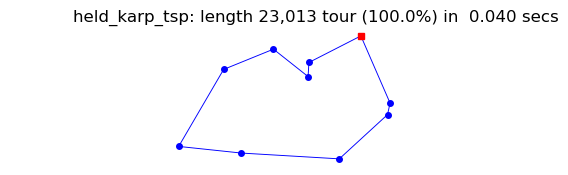

In [49]:
runs([held_karp_tsp, exhaustive_tsp], random_cities(10), [None])

We see that `held_karp_tsp` is a lot faster.  We can extend into uncharted territory  beyond the reach of  `exhaustive_tsp`:

[            held_karp_tsp: length 26,200 tour (100.0%) in  2.092 secs]

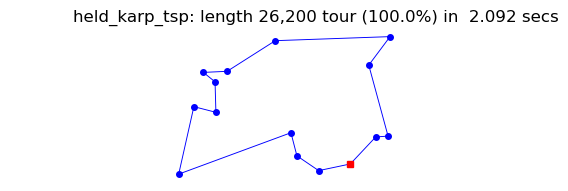

In [50]:
runs([held_karp_tsp], random_cities(15), [None])

Not bad! To see how much time we save using `held_karp_tsp` over `exhaustive_tsp`, we can extrapolate from the timings we've done, using the fact that Held-Karp is *O*(*n*<sup>2</sup> 2<sup>*n*</sup>) while Exhaustive Search is *O*(*n*!), to get this table:


|*n*|Exhaustive Search|Held Karp|
|---|---|---|
|10| 2 secs                | 0.04 secs |
|12|&approx; 4 mins   | 0.25 secs|
|15|&approx; 8 days |2 secs|
|25|&approx; <a href="https://www.google.com/search?q=2+seconds*25!+%2F+10!+in+years">270 billion years</a>|&approx; 95 minutes|



So if we had the patience to wait 95 minutes, `held_karp_tsp` could give us an answer on a 25-city problem that saves 270 billion years of computing compared to `exhaustive_tsp`.  The original Held-Karp algorithm had refinements that allowed it to handle 50-city sets in hours, not centuries, and could do so even with 1970s-era computing power! See **Branch and Cut** below.


# Review

Here are the algorithms we developed, grouped by strategy:

- **Brute Force Strategy**: `exhaustive_tsp`
- **Greedy Strategy**: `nearest_tsp`, `greedy_tsp`
- **Ensemble Strategy**: `rep_nearest_tsp`, `rep_opt2_nearest_tsp`
- **Improvement Strategy**: `opt2`
- **Divide and Conquer Strategy**: `divide_tsp`
- **Giant Shoulders Strategy**: `mst_tsp`, `held_karp_tsp`

# Benchmark Experiments on Algorithms

Which algorithm is best? I can't tell by trying them on only one or two problems. What I need to do is **benchmark** each algorithm on a standard **test set** of problems, and look at **statistical tests** to compare the algorithms. If the test set is large enough, the results will have statistical significance. If the test set is representative of the problems we want to solve, the results will have relevance. I'll build the following tools:
- `test_set`: A function to build a test set of *s* random sets of cities, each set with *n* cities.
- `benchmark`: A function to run an algorithm on a test set and record the results.
- `boxplots`: A function to plot the benchmark results of several algorithms.
- `rankings`: A function to print results of how many time each algorithm had the shortest tour, the second shortest, etc.

First the test sets:

In [51]:
TestSet = Tuple[Cities]

def test_set(s: int, n: int) -> TestSet:
    "Return `s` different sets of `n` random cities."
    return tuple(random_cities(n, seed=(s, i)) for i in range(s))

Next, the function `benchmark` takes as input a TSP function and a test set. It does a `run` of the function on each problem in the test set (possibly passing along `opt` and `kwds` values), and returns the list of `run` results. 

In [52]:
@cache
def benchmark(algorithm, tests, opt=None, **kwds) -> List[run]:
    "Benchmark one TSP algorithm on a test suite; return a list of `run`s."
    return [run(algorithm, test, opt=opt, **kwds) for test in tests]

A **boxplot** is a standard statistical visualization tool. I'll explain them when we see the output.

In [53]:
def boxplots(algorithms, tests: TestSet, opt=None, **kwds):
    "Draw a boxplot for each of the algorithms executing the tests."
    runslists = [benchmark(tsp, tests, opt=opt, **kwds) for tsp in algorithms]
    lengthlists = [[length(r) for r in runs] for runs in runslists]
    timelists   = [[r.secs for r in runs] for runs in runslists]
    best   = min(map(mean, lengthlists))
    labels = [boxplot_label(A, L, T, best) for (A, L, T) in zip(algorithms, lengthlists, timelists)]
    plt.figure(figsize=(15, 7.5))
    plt.grid(axis='y'); plt.ylabel('Mean Tour Length')
    plt.tick_params(axis='x', which='major', labelsize=12)
    plt.boxplot(lengthlists, labels=labels, showmeans=True, whis=(10, 90), sym='o', notch=True)
    plt.title(f"{len(tests)} sets of {len(tests[0])} cities with {opt.__name__ if opt else 'no'} optimization")

def boxplot_label(tsp, lengths, times, best):
    "A label for the bottom of the boxplot."
    return '{}\n{:.0f} ± {:.1f} msec\n{:,d} med len\n{:,d} ± {:,d} mean\n{:.2%} mean'.format(
           name(tsp), mean(times) * 1000, stdev(times) * 1000, 
           round(median(lengths)), round(mean(lengths)), round(stdev(lengths)), mean(lengths) / best)

def unzip(sequences): return zip(*sequences)

`rankings` produces a table comparing how many times each algorithm was best, second best etc., on a city-set.

In [54]:
def rankings(algorithms, tests: TestSet, opt=None, **kwds):
    "Print a table of how often each algorithm had each rank: you get a #1 if you were shortest."
    N = len(algorithms)
    runslists = [benchmark(tsp, tests, opt=opt, **kwds) for tsp in algorithms]
    lengthlists = [[round(length(r)) for r in runs] for runs in runslists]
    # ordered[i] is all tour lengths (for all algorithms) for the i-th problem, sorted
    ordered = [sorted(L) for L in zip(*lengthlists)]
    fmt = ('{:>4}' * len(algorithms) + ' | {}').format
    print(fmt(*['#' + str(i + 1) for i in range(N)], 'Algorithm'))
    print(' ---' * N + ' | ---------')
    for alg, lengths in zip(algorithms, lengthlists):
        ranks = Counter(ordered[i].index(lengths[i]) for i in range(len(tests)))
        print(fmt(*[ranks[i] for i in range(N)], name(alg)))

Finally, the function `compare` does both `rankings` and `boxplots`:

In [55]:
def compare(algorithms, tests=test_set(50, 200), opt=None):
    """Compare algorithms with boxplots and rankings."""
    rankings(algorithms, tests, opt=opt)
    boxplots(algorithms, tests, opt=opt)

# The Benchmarks

We'll start by comparing the 5 approximate algorithms on the default test set of 50 sets of 200 cities each:

  #1  #2  #3  #4  #5 | Algorithm
 --- --- --- --- --- | ---------
   1   5   5  38   1 | nearest_tsp
   9  17  23   1   0 | rep_nearest_tsp
  24  11  10   5   0 | greedy_tsp
  16  17  11   6   0 | divide_tsp
   0   0   1   0  49 | mst_tsp


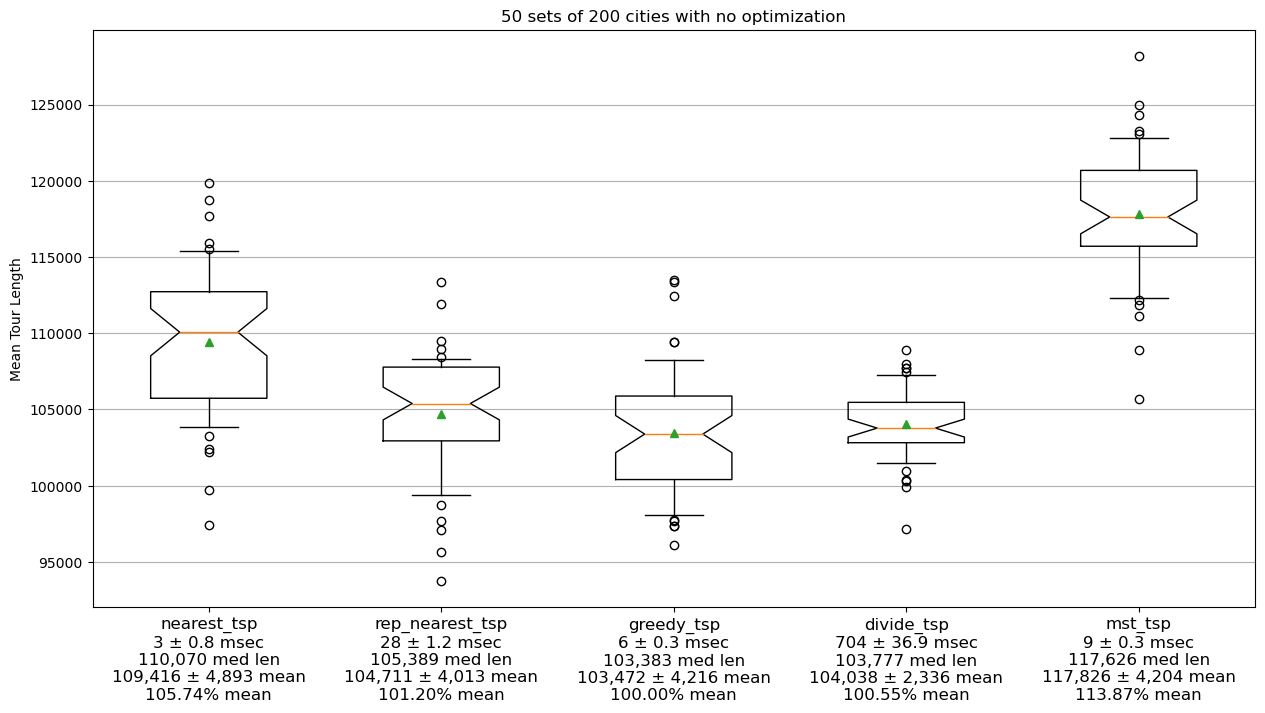

In [56]:
tsps = [nearest_tsp, rep_nearest_tsp, greedy_tsp, divide_tsp, mst_tsp]

compare(tsps)

The rankings tell us that the middle three algorithms each perform well in the rankings. Of the 50 city-sets, `rep_nearest_tsp` is best 9 times (and second-best 17 times), `greedy_tsp` is best 24 times, and `divide_tsp` best 16 times. `nearest_tsp` does consistently worse than `rep_nearest_tsp`, as expected, and `mst_tsp` finishes last 49 times out of 50.

In the boxplot, each column represents a data set (in this case, the 50 tour lengths for one algorithm) with a box covering the first to third quartiles of the data; inside the box is a horizontal line indicating the median and a triangle marker indicating the mean. The 10% and 90%  intervals are the "whiskers" coming out of the top and bottom of the box, and individual points outside that range are shown as dots. The "notches" in the sides of a boxes represent the 95% confidence interval on the median: if two boxes' notches do not overlap, that is strong evidence that the true medians of the algorithms differ. The label at the bottom of each column gives the name of the algorithm, the average run time in milliseconds (± standard deviation), the mean and median tour length (± standard deviation), and the percentage that the mean tour length of this algorithm is compared to the mean tour length of the best algorithm in this boxplot.

This boxplot says that the middle three algorithms all did about the same in tour length; their notches overlap, so we can't be confident that one is better than the others. (Although we can be confident that the greedy algorithm is the fastest of the three, especially compared to `divide_tsp`, and that `nearest_tsp` is faster still.) The minimum spanning tree algorithm produces by far the longest tours. 

Now let's repeat the benchmark with `opt2` applied to each result:

  #1  #2  #3  #4  #5 | Algorithm
 --- --- --- --- --- | ---------
   5  13  13  14   5 | nearest_tsp
  13  16   8  12   1 | rep_nearest_tsp
  29  12   7   2   0 | greedy_tsp
   0   2   2   5  41 | divide_tsp
   3   7  20  17   3 | mst_tsp


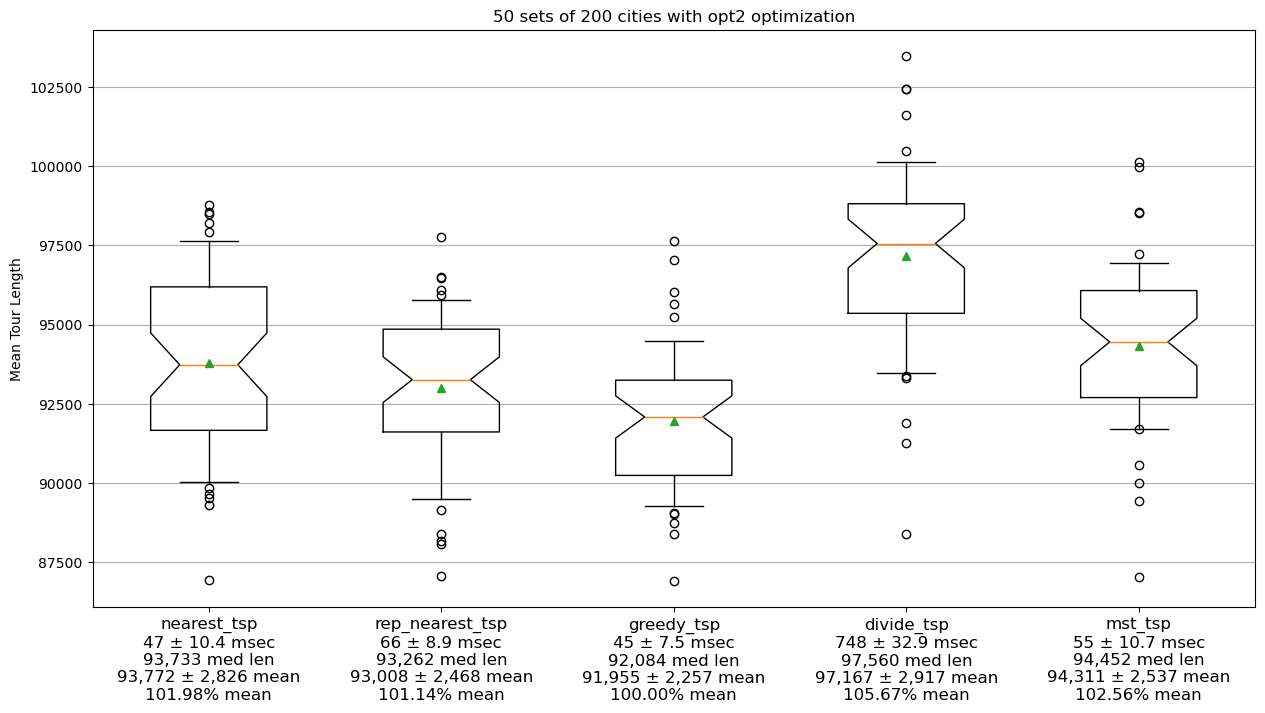

In [57]:
compare(tsps, opt=opt2)

This is interesting. Now `greedy_tsp` has increased its lead over `rep_nearest_tsp`, and `divide_tsp` is out of contention. Apparently, it is hard for `opt2` to optimize the types of tours produced by `divide_tsp`. On the other hand, `opt2` seems to have an easy time optimizing `mst_tsp`.

As far as run time goes, note that `greedy_tsp` is now faster than `nearest_tsp`, reversing the previous comparison. It seems that `opt2` runs faster on the tours produced by `greedy_tsp`. It should not be surprising that the speed of `opt2` depends on the tour; `opt2` has a `while` loop that will repeat a different number of times for different tours.

# Ensemble Strategy: `ensemble_tsp`

Since no one algorithm always dominates the others, maybe it is time for the **ensemble strategy**: try a bunch of TSP algorithms and choose the best tour that the bunch produces. There is a tradeoff of how much time you want to spend on this; I've included in the ensemble only the three algorithms with the best combination of short tours and fast run times on the benchmarks above.

In [58]:
ensemble = [rep_nearest_tsp, greedy_tsp, mst_tsp]

def ensemble_tsp(cities, algorithms=ensemble, opt=opt2): 
    "Apply an ensemble of algorithms to cities and take the shortest resulting tour."
    return shortest(run(tsp, cities, opt=opt).tour for tsp in algorithms)

The ensemble is doing more work, so I'll use a somewhat smaller test set.

  #1  #2  #3  #4 | Algorithm
 --- --- --- --- | ---------
  40   0   0   0 | ensemble_tsp
  12   0  17  11 | rep_nearest_tsp
  24   0  10   6 | greedy_tsp
   4   0  13  23 | mst_tsp


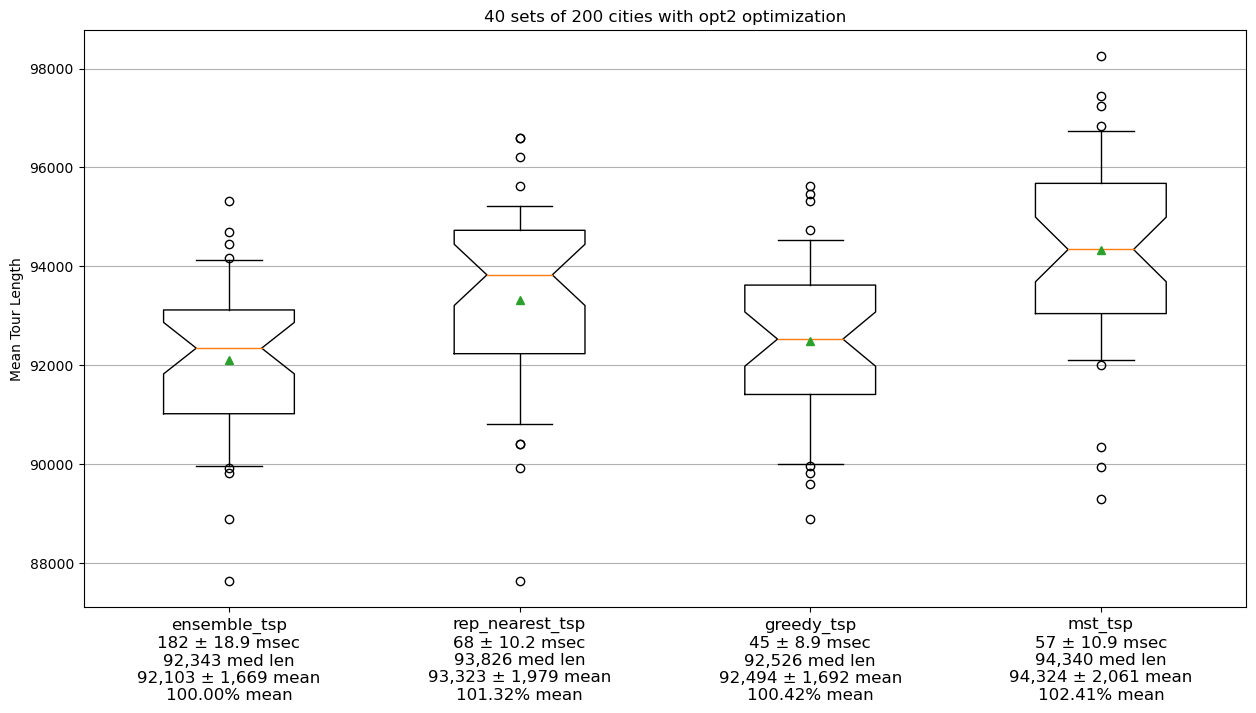

In [59]:
compare([ensemble_tsp] + ensemble, test_set(40, 200), opt=opt2)

For the rankings, note that there are only 40 problems, but 80 entries in the `#1` column. That's because for ties, the co-winners both appear in the `#1` column, and by definition, the `ensemble_tsp` will always tie with one of the components of the ensemble. All three component algorithms contribute to the ensemble.

For tour lengths, `ensemble_tsp` is the best (by definition), but only by a small amount. Is it worth it to more than triple the run time to get less than a 1% improvement in tour length over `greedy_tsp` alone?

# Different Sizes of City Sets

Let's see if the results are different for different-sized city sets. We had been doing 50 samples of 200-city sets; let's try 40 samples of 500-city sets. I'll just look at the three top (individual) algorithms, with `opt2` optimization:

  #1  #2  #3 | Algorithm
 --- --- --- | ---------
   7  29   4 | rep_nearest_tsp
  32   7   1 | greedy_tsp
   1   4  35 | mst_tsp


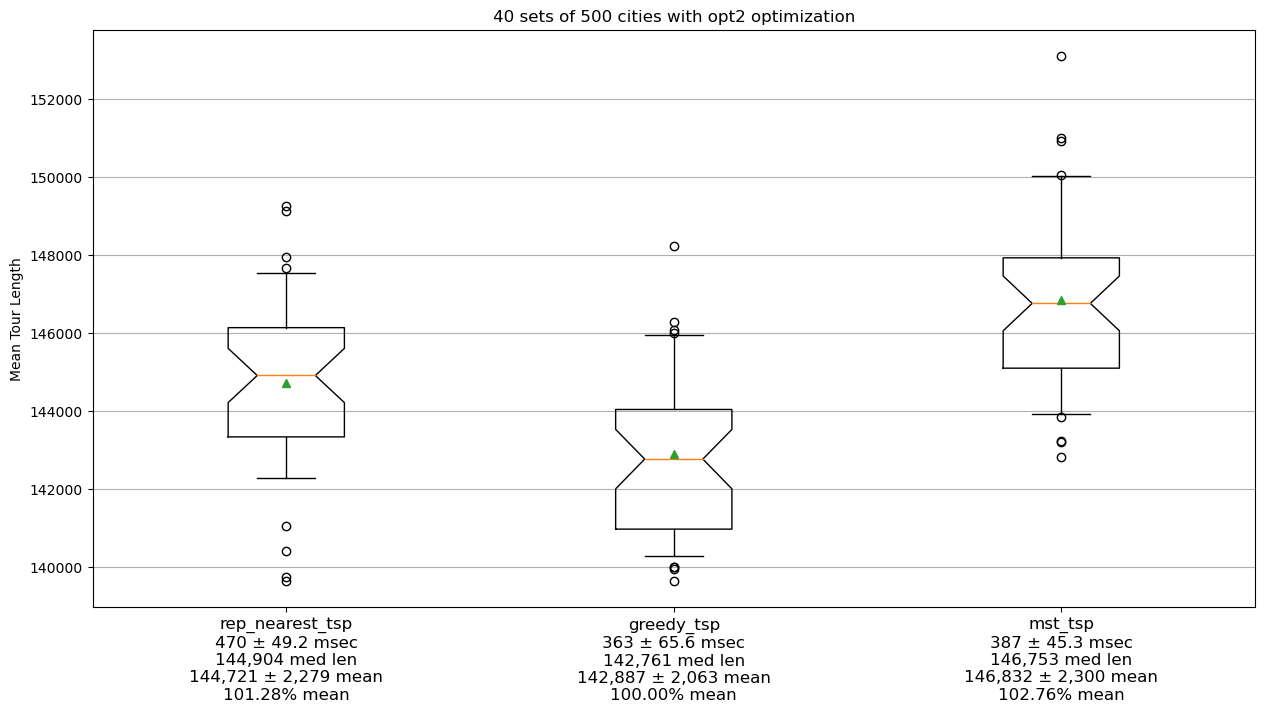

In [60]:
compare(ensemble, test_set(40, 500), opt=opt2)

At this size `greedy_tsp` is a more clear winner. 

What if the samples were not picked randomly from the 2-D plane, but rather from the USA map?

  #1  #2  #3 | Algorithm
 --- --- --- | ---------
  12  15  13 | rep_nearest_tsp
  25  11   4 | greedy_tsp
   3  14  23 | mst_tsp


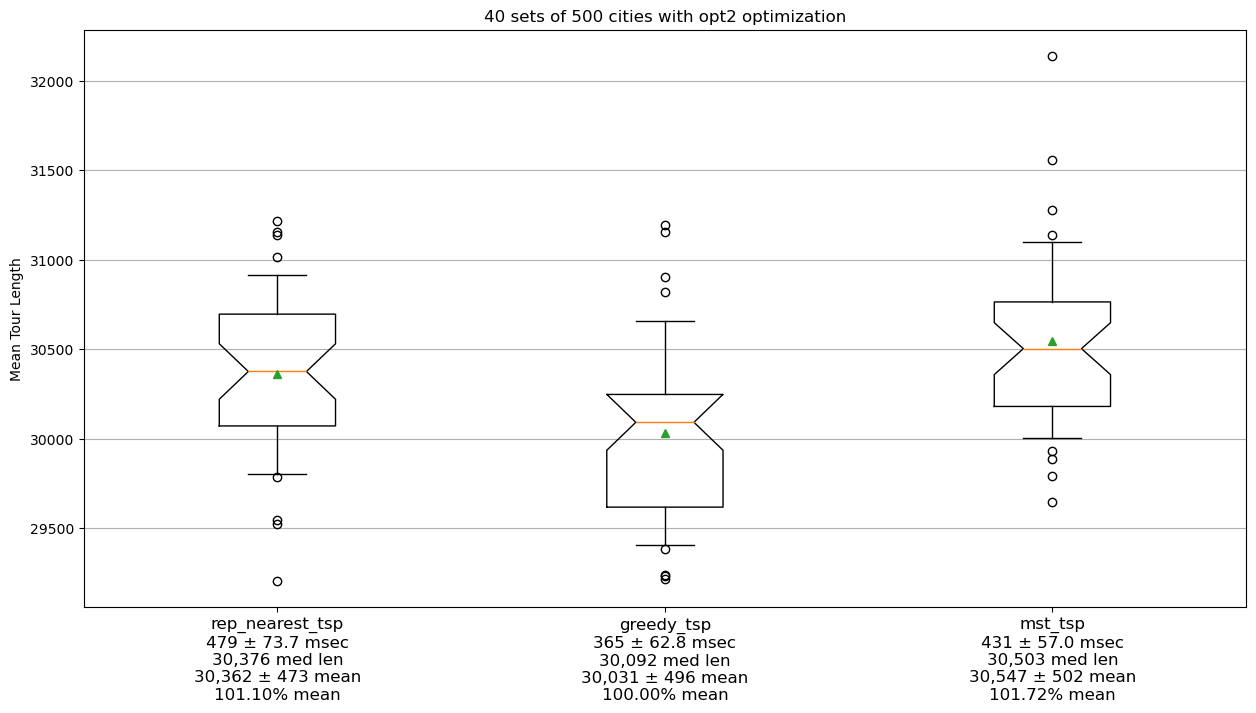

In [61]:
USA_test_set = tuple(Cities(sample(USA, 500, i)) for i in range(40))

compare(ensemble, USA_test_set, opt=opt2)

`greedy_tsp` still has the lead.

What happens when we go up to 1,000-city sets?

  #1  #2  #3 | Algorithm
 --- --- --- | ---------
   1  18   1 | rep_nearest_tsp
  19   1   0 | greedy_tsp
   0   1  19 | mst_tsp


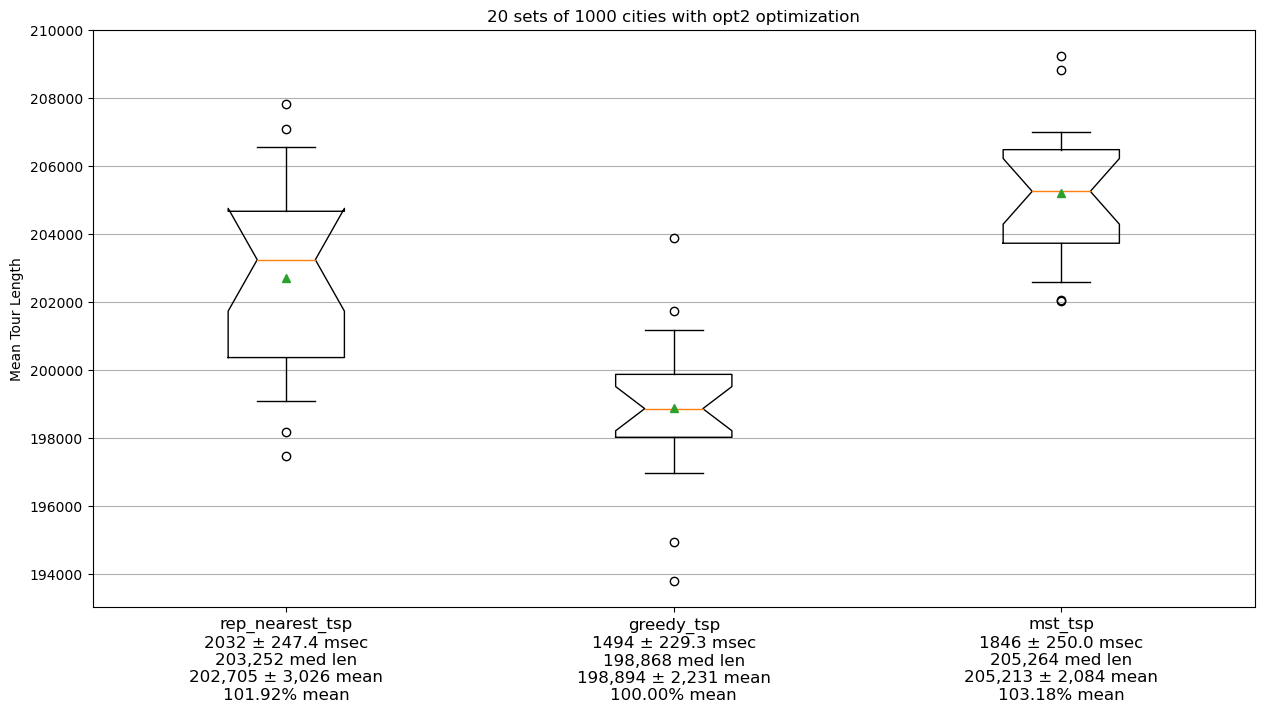

In [62]:
compare(ensemble, test_set(20, 1000), opt=opt2)

We get a similar picture, with `greedy_tsp` showing an even bigger lead. I'll stop here.

# Benchmarking Exact Algorithms

Here I compare the two exact algorithms, Exhaustive Search and Held-Karp, to the (approximate) ensemble algorithm. I'll try both 9 and 10-city test suites:

  #1  #2  #3 | Algorithm
 --- --- --- | ---------
  50   0   0 | exhaustive_tsp
  50   0   0 | held_karp_tsp
  43   0   7 | ensemble_tsp


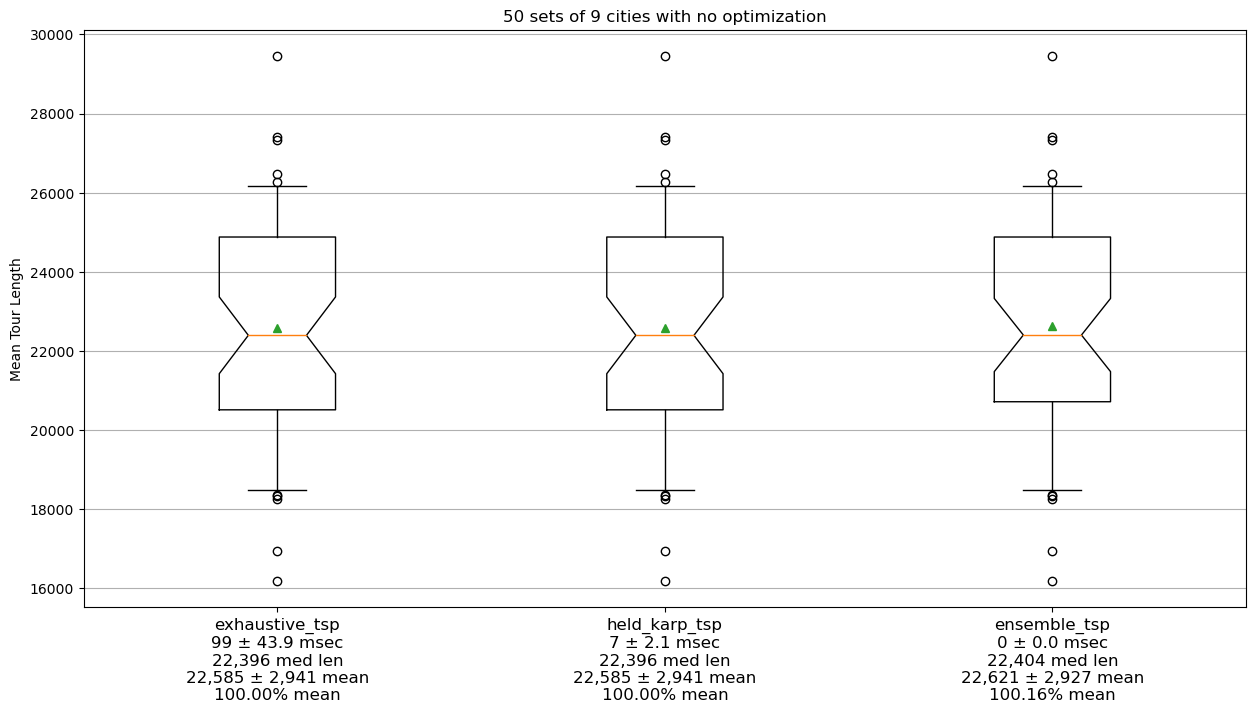

In [63]:
compare([exhaustive_tsp, held_karp_tsp, ensemble_tsp], test_set(50, 9))

  #1  #2  #3 | Algorithm
 --- --- --- | ---------
  30   0   0 | exhaustive_tsp
  30   0   0 | held_karp_tsp
  29   0   1 | ensemble_tsp


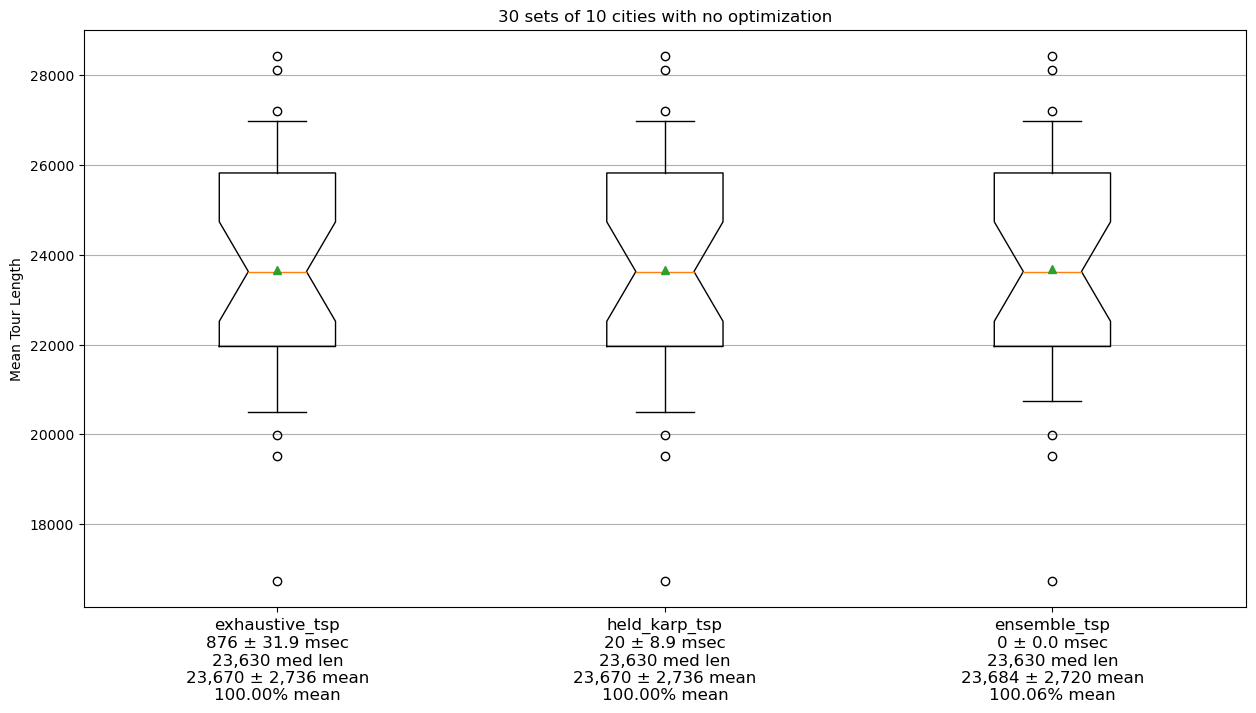

In [64]:
compare([exhaustive_tsp, held_karp_tsp, ensemble_tsp], test_set(30, 10))

This says that while `ensemble_tsp` does not give a guarantee of an optimal tour, in practice on small random city sets it performs almost as well as the exact algorithms (within 0.1%), only much faster.


# Further Explorations


That's all I'm going to write for now.  But there are still plenty of open questions for you to explore:

* **Branch and Cut**: this is a technique to cut off a search early, when a partial solution is obviously not optimal.  We saw how Held-Karp cuts off some permutations of cities when another permutation is better.  A refinement on that is to keep track of, say, the best total length of the segment going through all the Bs cities.  Then, any time you have a partial segment through some of the Bs cities that exceeds the best total, we can stop right there, before even finishing all the Bs.  With this technique, you can find optimal tours for around 50 cities.
* **Linear programming**: Look up the topic "linear programming" and see how it applies to TSP.
* **Heuristic Algorithms**: There are many approaches for using heurisitic estimates to find good (but not optimal) tours.  For example, *ant colony optimization algorithms* make random choices of which link to follow, and then the links that occur in the best tours get reinforced with some virtual pheromones, and other ants tend to follow those pheromones. *Simulated annealing* takes its inspiration from metallurgy.
* The **[Lin-Kernighan heuristic](http://akira.ruc.dk/~keld/research/LKH/LKH-1.3/DOC/LKH_REPORT.pdf)** is a generalization of `opt2` that can split the tour into more than two pieces, and considers all ways to put it back together. With such tricks, approximate algorithms  can handle hundreds of thousands of cities and come within 0.01% of the shortest possible tour.
* The **[Christofides algorithm](https://en.wikipedia.org/wiki/Christofides_algorithm)** gives a guarantee of 3/2 the optimal tour length (improving on the minimum-spanning-tree guarantee of 2).
* Can you explain why `mst_tsp` produces a guaranteed result, while `greedy_tsp` does not, even though the two algorithms have similar structure in the way they iterate over `shortest_links_first`?
* The code in this notebook was designed for clarity, not efficiency.  Can you make the code faster?
* **[William Cook](https://www.math.uwaterloo.ca/~bico/)** has a comprehensive 
[web page](http://www.math.uwaterloo.ca/tsp/) on the TSP, as well as a great 
[book](https://press.princeton.edu/titles/9531.html) and a
[draft chapter](http://www.math.uwaterloo.ca/~bico/papers/comp_chapter1.pdf) on Discrete Optimization featuring TSP. Like my notebook here, Cook's chapter goes through a variety of algorithms for TSP, describing each one in prose and code. His coding style is different because he uses C (in an imperative style) while I used Python (in a mostly functional style).  His code is much more efficient (but if it is 100 times faster, that might only mean two more cities on `exhaustive_tsp`). Cook  chooses a different set of algorithms to explore, with
more emphasis on optimizing algorithms that find guaranteed shortest tours. I find his explanations and code
are both beautiful and concise, and I think it is very interesting that
there can be two quite different approaches, which (in my opinion) both turn out very well. 
* If you are heavily into math, there's a [taxonomy](http://cstheory.stackexchange.com/questions/9241/approximation-algorithms-for-metric-tsp) of solutions.
* What else are you interested in?